## Note

* Small improvements over the 11.0 notebook
* New model: forward_backward_v3


## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import Normalizer, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import datetime
import os
import pickle

import sys
sys.path.append("../")
sys.path.append("../ext/OSTrack/")

from src.util import load_rects, draw_rect, HOTDataset, HOTDatasetMultiCam, save_rects
from src.eval import eval_results, eval_results_v2
from src.tracker import OSTrackWrapper, clip_box
from src.HyperTools import overlap_ratio

In [3]:
device = 'cuda'

## Data

In [4]:
dataset_type = "training"
dataset_path = f"/scratch/datasets/hot_2023/{dataset_type}"
dataset = HOTDatasetMultiCam(dataset_path)
scene_names = {}
for i in range(len(dataset)):
    name = dataset[i].name
    if name in scene_names:
        scene_names[name].append(i)
    else:
        scene_names[name] = [i]

scene_groups = list(scene_names.values())

scenes = np.arange(len(dataset))
rng = np.random.default_rng(seed = 15)
rng.shuffle(scene_groups)
train_n = int(len(scene_groups) * 0.9)
train_scenes = np.concatenate(scene_groups[:train_n])
test_scenes = np.concatenate(scene_groups[train_n:])
print("train / test split:", len(train_scenes), len(test_scenes))
test_scenes


val_dataset = HOTDatasetMultiCam("/scratch/datasets/hot_2023/validation")
val_scenes = np.arange(len(val_dataset))

train / test split: 96 14


## Tracking experiments

In [5]:
from tqdm.notebook import trange

def run_ostrack(ostrack: OSTrackWrapper, frames, init_bbox, start, end):
    if end > start:
        inc = 1
        desc = "forward"
    else:
        inc = -1
        desc = "backward"
    h,w = frames[start].shape[:2]
    bbox = clip_box(init_bbox, h, w, margin=5)
    ostrack.initialize(frames[start], bbox)
    track = [bbox]
    
    for i in trange(start + inc, end, inc, desc=desc):
        bbox = clip_box(bbox, h, w, margin=5)
        candidates, scores, response = ostrack.track(frames[i], bbox, 0)
        bbox = candidates[0].tolist()
        track.append(bbox)
    return np.array(track, dtype=int)

ostrack = OSTrackWrapper(
    use_hann=True,
    candidate_bbox_threshold=0.7,
    nms_iou_thresh=0.7,
    max_candidates=3
)

test config:  {'MODEL': {'PRETRAIN_FILE': 'mae_pretrain_vit_base.pth', 'EXTRA_MERGER': False, 'RETURN_INTER': False, 'RETURN_STAGES': [], 'BACKBONE': {'TYPE': 'vit_base_patch16_224_ce', 'STRIDE': 16, 'MID_PE': False, 'SEP_SEG': False, 'CAT_MODE': 'direct', 'MERGE_LAYER': 0, 'ADD_CLS_TOKEN': False, 'CLS_TOKEN_USE_MODE': 'ignore', 'CE_LOC': [3, 6, 9], 'CE_KEEP_RATIO': [0.7, 0.7, 0.7], 'CE_TEMPLATE_RANGE': 'CTR_POINT'}, 'HEAD': {'TYPE': 'CENTER', 'NUM_CHANNELS': 256}}, 'TRAIN': {'LR': 0.0004, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 300, 'LR_DROP_EPOCH': 240, 'BATCH_SIZE': 32, 'NUM_WORKER': 10, 'OPTIMIZER': 'ADAMW', 'BACKBONE_MULTIPLIER': 0.1, 'GIOU_WEIGHT': 2.0, 'L1_WEIGHT': 5.0, 'FREEZE_LAYERS': [0], 'PRINT_INTERVAL': 50, 'VAL_EPOCH_INTERVAL': 20, 'GRAD_CLIP_NORM': 0.1, 'AMP': False, 'CE_START_EPOCH': 20, 'CE_WARM_EPOCH': 80, 'DROP_PATH_RATE': 0.1, 'SCHEDULER': {'TYPE': 'step', 'DECAY_RATE': 0.1}}, 'DATA': {'SAMPLER_MODE': 'causal', 'MEAN': [0.485, 0.456, 0.406], 'STD': [0.229, 0.224, 0.225], '

In [6]:
def max_consecutives(x):
    if len(x) == 0:
        return 0
    x = sorted(x)
    max_consecutives = 1
    c = 1
    for i in range(len(x) - 1):
        if x[i] + 1 == x[i + 1]:
            c += 1
        else:
            max_consecutives = max(max_consecutives, c)
            c = 1
    return max(max_consecutives, c)

assert max_consecutives([0,1,2,4,5,7,8]) == 3
assert max_consecutives([0,1,3,4,5,6,7,8]) == 6
assert max_consecutives([0,2,5]) == 1
assert max_consecutives([]) == 0
assert max_consecutives([1]) == 1

In [7]:
def backward_forward(ostrack: OSTrackWrapper, frames, bbox_init, scene, debug=False, iou_thrsh=0.2):

    if debug:
        out_dir = f"../outputs/forward_backward/training/{scene.camera_type}/{scene.name}"
        os.makedirs(out_dir, exist_ok=True)
    niter = 0
    maxiter = 3
    start = 0
    end = len(frames)
    final_forward = np.full((len(frames), 4), -1)
    final_backward = None
    while start + 1 < end and niter < maxiter:
        niter += 1
        forward = run_ostrack(ostrack, frames, bbox_init, start, end)
        final_forward[start:end] = forward
        if debug:
            save_rects(os.path.join(out_dir, f"forward_{niter}.txt"), final_forward)
        consistent = False
        # bisect until backtracking is consistent
        _start = 0
        _end = len(forward)
        _backtracking_runs = 0
        while not consistent:
            _backtracking_runs += 1
            if debug:
                print("consistency check on:", start + _start, start + _end)
            backward = run_ostrack(ostrack, frames, forward[_end-1], _end - 1, _start - 1)
            backward = backward[::-1] # reverse
            if final_backward is None:
                final_backward = backward.copy()
                if debug:
                    save_rects(os.path.join(out_dir, f"backward_0.txt"), final_backward)
            
            iou = overlap_ratio(forward[_start:_end], backward[_start:_end])
            if debug:
                plt.plot(np.arange(start + _start, start + _end), iou, label=str(_backtracking_runs))
            idx = np.argwhere(iou < iou_thrsh) # inconsistency check
            if len(idx) == 0:
#             if len(idx) == 0:
                consistent = True
                continue
            last_consistent = np.max(idx)
            _end = (last_consistent - _start) // 2
            if _start + 1 >= _end:
                break

        if not consistent:
            if debug:
                print("failure to find consistent backtracking")
            break
        else:
            if debug:
                print("success, consistent range: ", start + _start, start + _end)
            final_backward[start+_start:start+_end] = backward
            if debug:
                save_rects(os.path.join(out_dir, f"backward_{niter}.txt"), final_backward)
            start = start + _end - 1
            bbox_init = forward[_end-1]
    
        if debug:
            plt.ylim(0,1)
            plt.legend()
            plt.show()
    return final_forward, final_backward
        
    
def interpolate_occluded(y_pred, occluded):
    anchors = np.argwhere(~occluded).flatten()
    y_out = y_pred.astype(np.float32)
    for i in range(len(anchors) - 1):
        start = anchors[i]
        end = anchors[i + 1]
        n = end - start
        if n == 1:
            continue
        y_out[start+1:end] = np.linspace(y_pred[start], y_pred[end], n+1)[1:-1]
    return y_out
    

In [8]:
version = "v3"

for scene in tqdm(scenes):
    print("scene id", scene)
    scene = dataset[scene]
    print("scene name", scene.name)
    
    output_dir = f"../outputs/model_predictions/forward-backward_{version}/{dataset.dataset_type}/{scene.camera_type}"
    pred_path = f"{output_dir}/{scene.name}.txt"
    
#     if os.path.exists(pred_path):
#         print("skipping - already exists")
#         continue
    
    frames = scene.falsecolor
    bbox_init = scene.y_true[0]
    forward, backward = backward_forward(ostrack, frames, bbox_init, scene, debug=False, iou_thrsh=0.2)
#     iou = overlap_ratio(forward, backward)
#     forward_int = interpolate_occluded(forward, iou < 0.2)
#     save_rects
    
    os.makedirs(output_dir, exist_ok=True)
    save_rects(pred_path, forward)

  0%|                                                                                          | 0/110 [00:00<?, ?it/s]

scene id 0
scene name officefan2


forward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/499 [00:00<?, ?it/s]

  1%|▋                                                                                 | 1/110 [00:13<23:47, 13.09s/it]

scene id 1
scene name cards11


forward:   0%|          | 0/624 [00:00<?, ?it/s]

backward:   0%|          | 0/624 [00:00<?, ?it/s]

backward:   0%|          | 0/275 [00:00<?, ?it/s]

forward:   0%|          | 0/349 [00:00<?, ?it/s]

backward:   0%|          | 0/349 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

forward:   0%|          | 0/340 [00:00<?, ?it/s]

backward:   0%|          | 0/340 [00:00<?, ?it/s]

backward:   0%|          | 0/91 [00:00<?, ?it/s]

  2%|█▍                                                                                | 2/110 [00:52<51:24, 28.56s/it]

scene id 2
scene name automobile10


forward:   0%|          | 0/458 [00:00<?, ?it/s]

backward:   0%|          | 0/458 [00:00<?, ?it/s]

backward:   0%|          | 0/94 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

forward:   0%|          | 0/427 [00:00<?, ?it/s]

backward:   0%|          | 0/427 [00:00<?, ?it/s]

backward:   0%|          | 0/190 [00:00<?, ?it/s]

backward:   0%|          | 0/79 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/425 [00:00<?, ?it/s]

backward:   0%|          | 0/425 [00:00<?, ?it/s]

backward:   0%|          | 0/190 [00:00<?, ?it/s]

backward:   0%|          | 0/77 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

  3%|██▏                                                                               | 3/110 [01:31<59:50, 33.55s/it]

scene id 3
scene name rider4


forward:   0%|          | 0/377 [00:00<?, ?it/s]

backward:   0%|          | 0/377 [00:00<?, ?it/s]

backward:   0%|          | 0/176 [00:00<?, ?it/s]

backward:   0%|          | 0/72 [00:00<?, ?it/s]

forward:   0%|          | 0/305 [00:00<?, ?it/s]

backward:   0%|          | 0/305 [00:00<?, ?it/s]

backward:   0%|          | 0/148 [00:00<?, ?it/s]

backward:   0%|          | 0/42 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/297 [00:00<?, ?it/s]

backward:   0%|          | 0/297 [00:00<?, ?it/s]

backward:   0%|          | 0/143 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

  4%|██▉                                                                               | 4/110 [02:02<57:28, 32.54s/it]

scene id 4
scene name pool5


forward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/196 [00:00<?, ?it/s]

backward:   0%|          | 0/77 [00:00<?, ?it/s]

forward:   0%|          | 0/422 [00:00<?, ?it/s]

backward:   0%|          | 0/422 [00:00<?, ?it/s]

backward:   0%|          | 0/209 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

forward:   0%|          | 0/405 [00:00<?, ?it/s]

backward:   0%|          | 0/405 [00:00<?, ?it/s]

backward:   0%|          | 0/200 [00:00<?, ?it/s]

backward:   0%|          | 0/97 [00:00<?, ?it/s]

backward:   0%|          | 0/46 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

  5%|███▋                                                                            | 5/110 [02:46<1:04:02, 36.59s/it]

scene id 5
scene name board


forward:   0%|          | 0/460 [00:00<?, ?it/s]

backward:   0%|          | 0/460 [00:00<?, ?it/s]

  5%|████▍                                                                             | 6/110 [02:57<48:07, 27.76s/it]

scene id 6
scene name car4


forward:   0%|          | 0/233 [00:00<?, ?it/s]

backward:   0%|          | 0/233 [00:00<?, ?it/s]

backward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

forward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

forward:   0%|          | 0/148 [00:00<?, ?it/s]

backward:   0%|          | 0/148 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

  6%|█████▏                                                                            | 7/110 [03:14<41:50, 24.37s/it]

scene id 7
scene name officechair1


forward:   0%|          | 0/524 [00:00<?, ?it/s]

backward:   0%|          | 0/524 [00:00<?, ?it/s]

  7%|█████▉                                                                            | 8/110 [03:27<35:01, 20.60s/it]

scene id 8
scene name car3


forward:   0%|          | 0/150 [00:00<?, ?it/s]

backward:   0%|          | 0/150 [00:00<?, ?it/s]

  8%|██████▋                                                                           | 9/110 [03:30<25:40, 15.25s/it]

scene id 9
scene name car9


forward:   0%|          | 0/307 [00:00<?, ?it/s]

backward:   0%|          | 0/307 [00:00<?, ?it/s]

backward:   0%|          | 0/102 [00:00<?, ?it/s]

forward:   0%|          | 0/205 [00:00<?, ?it/s]

backward:   0%|          | 0/205 [00:00<?, ?it/s]

backward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/197 [00:00<?, ?it/s]

backward:   0%|          | 0/197 [00:00<?, ?it/s]

backward:   0%|          | 0/97 [00:00<?, ?it/s]

backward:   0%|          | 0/42 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

  9%|███████▎                                                                         | 10/110 [03:52<28:35, 17.16s/it]

scene id 10
scene name rider3


forward:   0%|          | 0/406 [00:00<?, ?it/s]

backward:   0%|          | 0/406 [00:00<?, ?it/s]

backward:   0%|          | 0/189 [00:00<?, ?it/s]

backward:   0%|          | 0/74 [00:00<?, ?it/s]

forward:   0%|          | 0/332 [00:00<?, ?it/s]

backward:   0%|          | 0/332 [00:00<?, ?it/s]

backward:   0%|          | 0/140 [00:00<?, ?it/s]

backward:   0%|          | 0/62 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

forward:   0%|          | 0/323 [00:00<?, ?it/s]

backward:   0%|          | 0/323 [00:00<?, ?it/s]

backward:   0%|          | 0/159 [00:00<?, ?it/s]

backward:   0%|          | 0/74 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|████████                                                                         | 11/110 [04:26<36:58, 22.41s/it]

scene id 11
scene name automobile6


forward:   0%|          | 0/221 [00:00<?, ?it/s]

backward:   0%|          | 0/221 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

forward:   0%|          | 0/188 [00:00<?, ?it/s]

backward:   0%|          | 0/188 [00:00<?, ?it/s]

backward:   0%|          | 0/80 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/186 [00:00<?, ?it/s]

backward:   0%|          | 0/186 [00:00<?, ?it/s]

backward:   0%|          | 0/80 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|████████▊                                                                        | 12/110 [04:45<34:43, 21.26s/it]

scene id 12
scene name automobile


forward:   0%|          | 0/400 [00:00<?, ?it/s]

backward:   0%|          | 0/400 [00:00<?, ?it/s]

backward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

forward:   0%|          | 0/343 [00:00<?, ?it/s]

backward:   0%|          | 0/343 [00:00<?, ?it/s]

backward:   0%|          | 0/149 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

forward:   0%|          | 0/340 [00:00<?, ?it/s]

backward:   0%|          | 0/340 [00:00<?, ?it/s]

backward:   0%|          | 0/158 [00:00<?, ?it/s]

backward:   0%|          | 0/63 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 12%|█████████▌                                                                       | 13/110 [05:18<40:31, 25.07s/it]

scene id 13
scene name bus


forward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

 13%|██████████▎                                                                      | 14/110 [05:20<28:36, 17.88s/it]

scene id 14
scene name pedestrian4


forward:   0%|          | 0/341 [00:00<?, ?it/s]

backward:   0%|          | 0/341 [00:00<?, ?it/s]

backward:   0%|          | 0/76 [00:00<?, ?it/s]

forward:   0%|          | 0/265 [00:00<?, ?it/s]

backward:   0%|          | 0/265 [00:00<?, ?it/s]

backward:   0%|          | 0/131 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

forward:   0%|          | 0/240 [00:00<?, ?it/s]

backward:   0%|          | 0/240 [00:00<?, ?it/s]

backward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/54 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 14%|███████████                                                                      | 15/110 [05:46<32:15, 20.38s/it]

scene id 15
scene name automobile8


forward:   0%|          | 0/257 [00:00<?, ?it/s]

backward:   0%|          | 0/257 [00:00<?, ?it/s]

backward:   0%|          | 0/76 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/118 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/248 [00:00<?, ?it/s]

backward:   0%|          | 0/248 [00:00<?, ?it/s]

backward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|███████████▊                                                                     | 16/110 [06:09<33:19, 21.27s/it]

scene id 16
scene name automobile2


forward:   0%|          | 0/531 [00:00<?, ?it/s]

backward:   0%|          | 0/531 [00:00<?, ?it/s]

backward:   0%|          | 0/250 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/529 [00:00<?, ?it/s]

backward:   0%|          | 0/529 [00:00<?, ?it/s]

backward:   0%|          | 0/256 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

forward:   0%|          | 0/510 [00:00<?, ?it/s]

backward:   0%|          | 0/510 [00:00<?, ?it/s]

backward:   0%|          | 0/248 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

 15%|████████████▌                                                                    | 17/110 [07:00<46:43, 30.14s/it]

scene id 17
scene name automobile13


forward:   0%|          | 0/251 [00:00<?, ?it/s]

backward:   0%|          | 0/251 [00:00<?, ?it/s]

backward:   0%|          | 0/93 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

forward:   0%|          | 0/248 [00:00<?, ?it/s]

backward:   0%|          | 0/248 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

forward:   0%|          | 0/167 [00:00<?, ?it/s]

backward:   0%|          | 0/167 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

 16%|█████████████▎                                                                   | 18/110 [07:19<40:54, 26.68s/it]

scene id 18
scene name car7


forward:   0%|          | 0/354 [00:00<?, ?it/s]

backward:   0%|          | 0/354 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

forward:   0%|          | 0/345 [00:00<?, ?it/s]

backward:   0%|          | 0/345 [00:00<?, ?it/s]

backward:   0%|          | 0/164 [00:00<?, ?it/s]

forward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

 17%|█████████████▉                                                                   | 19/110 [07:43<39:25, 25.99s/it]

scene id 19
scene name glass2


forward:   0%|          | 0/424 [00:00<?, ?it/s]

backward:   0%|          | 0/424 [00:00<?, ?it/s]

 18%|██████████████▋                                                                  | 20/110 [07:53<31:50, 21.23s/it]

scene id 20
scene name automobile14


forward:   0%|          | 0/236 [00:00<?, ?it/s]

backward:   0%|          | 0/236 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

forward:   0%|          | 0/150 [00:00<?, ?it/s]

backward:   0%|          | 0/150 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

 19%|███████████████▍                                                                 | 21/110 [08:04<26:53, 18.13s/it]

scene id 21
scene name automobile5


forward:   0%|          | 0/370 [00:00<?, ?it/s]

backward:   0%|          | 0/370 [00:00<?, ?it/s]

backward:   0%|          | 0/174 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

forward:   0%|          | 0/333 [00:00<?, ?it/s]

backward:   0%|          | 0/333 [00:00<?, ?it/s]

backward:   0%|          | 0/161 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

forward:   0%|          | 0/293 [00:00<?, ?it/s]

backward:   0%|          | 0/293 [00:00<?, ?it/s]

backward:   0%|          | 0/141 [00:00<?, ?it/s]

backward:   0%|          | 0/66 [00:00<?, ?it/s]

 20%|████████████████▏                                                                | 22/110 [08:35<32:15, 21.99s/it]

scene id 22
scene name car10


forward:   0%|          | 0/301 [00:00<?, ?it/s]

backward:   0%|          | 0/301 [00:00<?, ?it/s]

backward:   0%|          | 0/142 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

forward:   0%|          | 0/261 [00:00<?, ?it/s]

backward:   0%|          | 0/261 [00:00<?, ?it/s]

backward:   0%|          | 0/107 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/255 [00:00<?, ?it/s]

backward:   0%|          | 0/255 [00:00<?, ?it/s]

backward:   0%|          | 0/113 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 21%|████████████████▉                                                                | 23/110 [09:01<33:30, 23.11s/it]

scene id 23
scene name pedestrian3


forward:   0%|          | 0/333 [00:00<?, ?it/s]

backward:   0%|          | 0/333 [00:00<?, ?it/s]

backward:   0%|          | 0/154 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

forward:   0%|          | 0/319 [00:00<?, ?it/s]

backward:   0%|          | 0/319 [00:00<?, ?it/s]

backward:   0%|          | 0/152 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 22%|█████████████████▋                                                               | 24/110 [09:20<31:36, 22.06s/it]

scene id 24
scene name whitecup3


forward:   0%|          | 0/424 [00:00<?, ?it/s]

backward:   0%|          | 0/424 [00:00<?, ?it/s]

backward:   0%|          | 0/179 [00:00<?, ?it/s]

backward:   0%|          | 0/70 [00:00<?, ?it/s]

forward:   0%|          | 0/354 [00:00<?, ?it/s]

backward:   0%|          | 0/354 [00:00<?, ?it/s]

backward:   0%|          | 0/174 [00:00<?, ?it/s]

backward:   0%|          | 0/84 [00:00<?, ?it/s]

backward:   0%|          | 0/38 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██████████████████▍                                                              | 25/110 [09:46<32:39, 23.05s/it]

scene id 25
scene name rainystreet2


forward:   0%|          | 0/261 [00:00<?, ?it/s]

backward:   0%|          | 0/261 [00:00<?, ?it/s]

backward:   0%|          | 0/128 [00:00<?, ?it/s]

backward:   0%|          | 0/61 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

forward:   0%|          | 0/241 [00:00<?, ?it/s]

backward:   0%|          | 0/241 [00:00<?, ?it/s]

backward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/240 [00:00<?, ?it/s]

backward:   0%|          | 0/240 [00:00<?, ?it/s]

backward:   0%|          | 0/98 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|███████████████████▏                                                             | 26/110 [10:10<32:50, 23.46s/it]

scene id 26
scene name toy2


forward:   0%|          | 0/400 [00:00<?, ?it/s]

backward:   0%|          | 0/400 [00:00<?, ?it/s]

 25%|███████████████████▉                                                             | 27/110 [10:20<26:38, 19.26s/it]

scene id 27
scene name partylights3


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

forward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

 25%|████████████████████▌                                                            | 28/110 [10:35<24:39, 18.04s/it]

scene id 28
scene name car8


forward:   0%|          | 0/363 [00:00<?, ?it/s]

backward:   0%|          | 0/363 [00:00<?, ?it/s]

backward:   0%|          | 0/117 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

forward:   0%|          | 0/316 [00:00<?, ?it/s]

backward:   0%|          | 0/316 [00:00<?, ?it/s]

backward:   0%|          | 0/145 [00:00<?, ?it/s]

backward:   0%|          | 0/59 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

 26%|█████████████████████▎                                                           | 29/110 [10:56<25:28, 18.87s/it]

scene id 29
scene name car2


forward:   0%|          | 0/269 [00:00<?, ?it/s]

backward:   0%|          | 0/269 [00:00<?, ?it/s]

 27%|██████████████████████                                                           | 30/110 [11:02<20:10, 15.13s/it]

scene id 30
scene name pedestrian


forward:   0%|          | 0/270 [00:00<?, ?it/s]

backward:   0%|          | 0/270 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/126 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/251 [00:00<?, ?it/s]

backward:   0%|          | 0/251 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/41 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 28%|██████████████████████▊                                                          | 31/110 [11:25<22:57, 17.43s/it]

scene id 31
scene name rider2


forward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

forward:   0%|          | 0/199 [00:00<?, ?it/s]

backward:   0%|          | 0/199 [00:00<?, ?it/s]

backward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/198 [00:00<?, ?it/s]

backward:   0%|          | 0/198 [00:00<?, ?it/s]

backward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|███████████████████████▌                                                         | 32/110 [11:43<23:05, 17.77s/it]

scene id 32
scene name taxi


forward:   0%|          | 0/287 [00:00<?, ?it/s]

backward:   0%|          | 0/287 [00:00<?, ?it/s]

backward:   0%|          | 0/135 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

forward:   0%|          | 0/272 [00:00<?, ?it/s]

backward:   0%|          | 0/272 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

forward:   0%|          | 0/207 [00:00<?, ?it/s]

backward:   0%|          | 0/207 [00:00<?, ?it/s]

backward:   0%|          | 0/72 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

 30%|████████████████████████▎                                                        | 33/110 [12:06<24:42, 19.26s/it]

scene id 33
scene name automobile7


forward:   0%|          | 0/246 [00:00<?, ?it/s]

backward:   0%|          | 0/246 [00:00<?, ?it/s]

backward:   0%|          | 0/98 [00:00<?, ?it/s]

forward:   0%|          | 0/148 [00:00<?, ?it/s]

backward:   0%|          | 0/148 [00:00<?, ?it/s]

backward:   0%|          | 0/69 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

forward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████                                                        | 34/110 [12:22<22:57, 18.13s/it]

scene id 34
scene name automobile11


forward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/54 [00:00<?, ?it/s]

forward:   0%|          | 0/149 [00:00<?, ?it/s]

backward:   0%|          | 0/149 [00:00<?, ?it/s]

backward:   0%|          | 0/66 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

 32%|█████████████████████████▊                                                       | 35/110 [12:32<19:38, 15.71s/it]

scene id 35
scene name car5


forward:   0%|          | 0/300 [00:00<?, ?it/s]

backward:   0%|          | 0/300 [00:00<?, ?it/s]

backward:   0%|          | 0/116 [00:00<?, ?it/s]

forward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/84 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/182 [00:00<?, ?it/s]

backward:   0%|          | 0/182 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

 33%|██████████████████████████▌                                                      | 36/110 [12:51<20:43, 16.80s/it]

scene id 36
scene name rainystreet5


forward:   0%|          | 0/674 [00:00<?, ?it/s]

backward:   0%|          | 0/674 [00:00<?, ?it/s]

backward:   0%|          | 0/140 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/662 [00:00<?, ?it/s]

backward:   0%|          | 0/662 [00:00<?, ?it/s]

backward:   0%|          | 0/132 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/656 [00:00<?, ?it/s]

backward:   0%|          | 0/656 [00:00<?, ?it/s]

 34%|███████████████████████████▏                                                     | 37/110 [13:42<33:02, 27.16s/it]

scene id 37
scene name dice1


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/189 [00:00<?, ?it/s]

forward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/84 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 35%|███████████████████████████▉                                                     | 38/110 [14:07<31:42, 26.43s/it]

scene id 38
scene name pedestrian2


forward:   0%|          | 0/580 [00:00<?, ?it/s]

backward:   0%|          | 0/580 [00:00<?, ?it/s]

backward:   0%|          | 0/146 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

forward:   0%|          | 0/557 [00:00<?, ?it/s]

backward:   0%|          | 0/557 [00:00<?, ?it/s]

backward:   0%|          | 0/163 [00:00<?, ?it/s]

backward:   0%|          | 0/68 [00:00<?, ?it/s]

backward:   0%|          | 0/27 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

forward:   0%|          | 0/547 [00:00<?, ?it/s]

backward:   0%|          | 0/547 [00:00<?, ?it/s]

backward:   0%|          | 0/256 [00:00<?, ?it/s]

backward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/56 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

 35%|████████████████████████████▋                                                    | 39/110 [14:58<39:58, 33.78s/it]

scene id 39
scene name bytheriver1


forward:   0%|          | 0/524 [00:00<?, ?it/s]

backward:   0%|          | 0/524 [00:00<?, ?it/s]

 36%|█████████████████████████████▍                                                   | 40/110 [15:11<31:58, 27.41s/it]

scene id 40
scene name car1


forward:   0%|          | 0/205 [00:00<?, ?it/s]

backward:   0%|          | 0/205 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/204 [00:00<?, ?it/s]

 37%|██████████████████████████████▏                                                  | 41/110 [15:20<25:26, 22.12s/it]

scene id 41
scene name automobile4


forward:   0%|          | 0/200 [00:00<?, ?it/s]

backward:   0%|          | 0/200 [00:00<?, ?it/s]

backward:   0%|          | 0/76 [00:00<?, ?it/s]

forward:   0%|          | 0/124 [00:00<?, ?it/s]

backward:   0%|          | 0/124 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 38%|██████████████████████████████▉                                                  | 42/110 [15:34<22:05, 19.49s/it]

scene id 42
scene name rider1


forward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/89 [00:00<?, ?it/s]

forward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

forward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/46 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

 39%|███████████████████████████████▋                                                 | 43/110 [15:46<19:27, 17.42s/it]

scene id 43
scene name ball&mirror7


forward:   0%|          | 0/299 [00:00<?, ?it/s]

backward:   0%|          | 0/299 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

forward:   0%|          | 0/213 [00:00<?, ?it/s]

backward:   0%|          | 0/213 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/211 [00:00<?, ?it/s]

backward:   0%|          | 0/211 [00:00<?, ?it/s]

backward:   0%|          | 0/102 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████████████████████████████████▍                                                | 44/110 [16:09<20:46, 18.89s/it]

scene id 44
scene name automobile12


forward:   0%|          | 0/235 [00:00<?, ?it/s]

backward:   0%|          | 0/235 [00:00<?, ?it/s]

 41%|█████████████████████████████████▏                                               | 45/110 [16:14<16:08, 14.90s/it]

scene id 45
scene name automobile3


forward:   0%|          | 0/288 [00:00<?, ?it/s]

backward:   0%|          | 0/288 [00:00<?, ?it/s]

backward:   0%|          | 0/139 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/120 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

 42%|█████████████████████████████████▊                                               | 46/110 [16:31<16:30, 15.48s/it]

scene id 46
scene name duck3


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/197 [00:00<?, ?it/s]

forward:   0%|          | 0/202 [00:00<?, ?it/s]

backward:   0%|          | 0/202 [00:00<?, ?it/s]

backward:   0%|          | 0/99 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|██████████████████████████████████▌                                              | 47/110 [16:50<17:18, 16.49s/it]

scene id 47
scene name automobile9


forward:   0%|          | 0/207 [00:00<?, ?it/s]

backward:   0%|          | 0/207 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

forward:   0%|          | 0/150 [00:00<?, ?it/s]

backward:   0%|          | 0/150 [00:00<?, ?it/s]

backward:   0%|          | 0/70 [00:00<?, ?it/s]

backward:   0%|          | 0/29 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

 44%|███████████████████████████████████▎                                             | 48/110 [17:00<15:11, 14.71s/it]

scene id 48
scene name car6


forward:   0%|          | 0/384 [00:00<?, ?it/s]

backward:   0%|          | 0/384 [00:00<?, ?it/s]

backward:   0%|          | 0/169 [00:00<?, ?it/s]

backward:   0%|          | 0/36 [00:00<?, ?it/s]

forward:   0%|          | 0/348 [00:00<?, ?it/s]

backward:   0%|          | 0/348 [00:00<?, ?it/s]

backward:   0%|          | 0/167 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

forward:   0%|          | 0/329 [00:00<?, ?it/s]

backward:   0%|          | 0/329 [00:00<?, ?it/s]

backward:   0%|          | 0/153 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

 45%|████████████████████████████████████                                             | 49/110 [17:33<20:20, 20.01s/it]

scene id 49
scene name cloth1


forward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/274 [00:00<?, ?it/s]

 45%|████████████████████████████████████▊                                            | 50/110 [17:40<16:03, 16.06s/it]

scene id 50
scene name basketball


forward:   0%|          | 0/777 [00:00<?, ?it/s]

backward:   0%|          | 0/777 [00:00<?, ?it/s]

backward:   0%|          | 0/387 [00:00<?, ?it/s]

backward:   0%|          | 0/187 [00:00<?, ?it/s]

backward:   0%|          | 0/71 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/775 [00:00<?, ?it/s]

backward:   0%|          | 0/775 [00:00<?, ?it/s]

backward:   0%|          | 0/384 [00:00<?, ?it/s]

backward:   0%|          | 0/190 [00:00<?, ?it/s]

backward:   0%|          | 0/93 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 46%|█████████████████████████████████████▌                                           | 51/110 [18:33<26:46, 27.22s/it]

scene id 51
scene name toy


forward:   0%|          | 0/500 [00:00<?, ?it/s]

backward:   0%|          | 0/500 [00:00<?, ?it/s]

backward:   0%|          | 0/238 [00:00<?, ?it/s]

backward:   0%|          | 0/110 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

forward:   0%|          | 0/465 [00:00<?, ?it/s]

backward:   0%|          | 0/465 [00:00<?, ?it/s]

backward:   0%|          | 0/228 [00:00<?, ?it/s]

backward:   0%|          | 0/106 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

 47%|██████████████████████████████████████▎                                          | 52/110 [19:05<27:35, 28.53s/it]

scene id 52
scene name bus2


forward:   0%|          | 0/171 [00:00<?, ?it/s]

backward:   0%|          | 0/171 [00:00<?, ?it/s]

backward:   0%|          | 0/34 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

forward:   0%|          | 0/162 [00:00<?, ?it/s]

backward:   0%|          | 0/162 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

forward:   0%|          | 0/129 [00:00<?, ?it/s]

backward:   0%|          | 0/129 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 48%|███████████████████████████████████████                                          | 53/110 [19:18<22:43, 23.92s/it]

scene id 53
scene name kangaroo


forward:   0%|          | 0/440 [00:00<?, ?it/s]

backward:   0%|          | 0/440 [00:00<?, ?it/s]

backward:   0%|          | 0/212 [00:00<?, ?it/s]

forward:   0%|          | 0/228 [00:00<?, ?it/s]

backward:   0%|          | 0/228 [00:00<?, ?it/s]

backward:   0%|          | 0/106 [00:00<?, ?it/s]

forward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/122 [00:00<?, ?it/s]

 49%|███████████████████████████████████████▊                                         | 54/110 [19:40<21:50, 23.41s/it]

scene id 54
scene name receipts3


forward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/98 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

forward:   0%|          | 0/313 [00:00<?, ?it/s]

backward:   0%|          | 0/313 [00:00<?, ?it/s]

backward:   0%|          | 0/94 [00:00<?, ?it/s]

forward:   0%|          | 0/219 [00:00<?, ?it/s]

backward:   0%|          | 0/219 [00:00<?, ?it/s]

backward:   0%|          | 0/108 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

 50%|████████████████████████████████████████▌                                        | 55/110 [20:06<22:09, 24.16s/it]

scene id 55
scene name car22


forward:   0%|          | 0/172 [00:00<?, ?it/s]

backward:   0%|          | 0/172 [00:00<?, ?it/s]

 51%|█████████████████████████████████████████▏                                       | 56/110 [20:10<16:19, 18.15s/it]

scene id 56
scene name car28


forward:   0%|          | 0/235 [00:00<?, ?it/s]

backward:   0%|          | 0/235 [00:00<?, ?it/s]

backward:   0%|          | 0/108 [00:00<?, ?it/s]

forward:   0%|          | 0/127 [00:00<?, ?it/s]

backward:   0%|          | 0/127 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████▉                                       | 57/110 [20:20<13:51, 15.68s/it]

scene id 57
scene name bus3


forward:   0%|          | 0/171 [00:00<?, ?it/s]

backward:   0%|          | 0/171 [00:00<?, ?it/s]

backward:   0%|          | 0/36 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

forward:   0%|          | 0/161 [00:00<?, ?it/s]

backward:   0%|          | 0/161 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/149 [00:00<?, ?it/s]

backward:   0%|          | 0/149 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/27 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 53%|██████████████████████████████████████████▋                                      | 58/110 [20:34<13:15, 15.30s/it]

scene id 58
scene name car31


forward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████▍                                     | 59/110 [20:37<09:44, 11.46s/it]

scene id 59
scene name pedestrian5


forward:   0%|          | 0/362 [00:00<?, ?it/s]

backward:   0%|          | 0/362 [00:00<?, ?it/s]

backward:   0%|          | 0/139 [00:00<?, ?it/s]

forward:   0%|          | 0/223 [00:00<?, ?it/s]

backward:   0%|          | 0/223 [00:00<?, ?it/s]

backward:   0%|          | 0/102 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/217 [00:00<?, ?it/s]

backward:   0%|          | 0/217 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▏                                    | 60/110 [21:01<12:41, 15.24s/it]

scene id 60
scene name car36


forward:   0%|          | 0/354 [00:00<?, ?it/s]

backward:   0%|          | 0/354 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

forward:   0%|          | 0/289 [00:00<?, ?it/s]

backward:   0%|          | 0/289 [00:00<?, ?it/s]

backward:   0%|          | 0/135 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

forward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/120 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████▉                                    | 61/110 [21:27<15:06, 18.50s/it]

scene id 61
scene name car41


forward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

forward:   0%|          | 0/83 [00:00<?, ?it/s]

backward:   0%|          | 0/83 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

forward:   0%|          | 0/79 [00:00<?, ?it/s]

backward:   0%|          | 0/79 [00:00<?, ?it/s]

backward:   0%|          | 0/36 [00:00<?, ?it/s]

 56%|█████████████████████████████████████████████▋                                   | 62/110 [21:33<11:55, 14.90s/it]

scene id 62
scene name bus4


forward:   0%|          | 0/73 [00:00<?, ?it/s]

backward:   0%|          | 0/73 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████▍                                  | 63/110 [21:35<08:35, 10.97s/it]

scene id 63
scene name car17


forward:   0%|          | 0/140 [00:00<?, ?it/s]

backward:   0%|          | 0/140 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

forward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

forward:   0%|          | 0/95 [00:00<?, ?it/s]

backward:   0%|          | 0/95 [00:00<?, ?it/s]

backward:   0%|          | 0/30 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████▏                                 | 64/110 [21:45<08:11, 10.68s/it]

scene id 64
scene name rider7


forward:   0%|          | 0/94 [00:00<?, ?it/s]

backward:   0%|          | 0/94 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████▊                                 | 65/110 [21:47<06:06,  8.15s/it]

scene id 65
scene name car25


forward:   0%|          | 0/256 [00:00<?, ?it/s]

backward:   0%|          | 0/256 [00:00<?, ?it/s]

backward:   0%|          | 0/118 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/250 [00:00<?, ?it/s]

backward:   0%|          | 0/250 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/245 [00:00<?, ?it/s]

backward:   0%|          | 0/245 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████▌                                | 66/110 [22:10<09:08, 12.47s/it]

scene id 66
scene name car21


forward:   0%|          | 0/189 [00:00<?, ?it/s]

backward:   0%|          | 0/189 [00:00<?, ?it/s]

backward:   0%|          | 0/73 [00:00<?, ?it/s]

forward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

forward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

 61%|█████████████████████████████████████████████████▎                               | 67/110 [22:20<08:28, 11.83s/it]

scene id 67
scene name car19


forward:   0%|          | 0/62 [00:00<?, ?it/s]

backward:   0%|          | 0/62 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

forward:   0%|          | 0/38 [00:00<?, ?it/s]

backward:   0%|          | 0/38 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/37 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████                               | 68/110 [22:24<06:39,  9.51s/it]

scene id 68
scene name car13


forward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

forward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

forward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/38 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

 63%|██████████████████████████████████████████████████▊                              | 69/110 [22:34<06:35,  9.64s/it]

scene id 69
scene name car32


forward:   0%|          | 0/384 [00:00<?, ?it/s]

backward:   0%|          | 0/384 [00:00<?, ?it/s]

backward:   0%|          | 0/145 [00:00<?, ?it/s]

backward:   0%|          | 0/38 [00:00<?, ?it/s]

forward:   0%|          | 0/346 [00:00<?, ?it/s]

backward:   0%|          | 0/346 [00:00<?, ?it/s]

backward:   0%|          | 0/165 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████▌                             | 70/110 [22:57<08:57, 13.43s/it]

scene id 70
scene name car38


forward:   0%|          | 0/531 [00:00<?, ?it/s]

backward:   0%|          | 0/531 [00:00<?, ?it/s]

backward:   0%|          | 0/225 [00:00<?, ?it/s]

backward:   0%|          | 0/90 [00:00<?, ?it/s]

forward:   0%|          | 0/441 [00:00<?, ?it/s]

backward:   0%|          | 0/441 [00:00<?, ?it/s]

backward:   0%|          | 0/188 [00:00<?, ?it/s]

forward:   0%|          | 0/253 [00:00<?, ?it/s]

backward:   0%|          | 0/253 [00:00<?, ?it/s]

backward:   0%|          | 0/85 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████▎                            | 71/110 [23:33<13:09, 20.25s/it]

scene id 71
scene name rider12


forward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

forward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/56 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

forward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/46 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████                            | 72/110 [23:46<11:23, 18.00s/it]

scene id 72
scene name car35


forward:   0%|          | 0/269 [00:00<?, ?it/s]

backward:   0%|          | 0/269 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/264 [00:00<?, ?it/s]

backward:   0%|          | 0/264 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/29 [00:00<?, ?it/s]

 66%|█████████████████████████████████████████████████████▊                           | 73/110 [24:05<11:21, 18.43s/it]

scene id 73
scene name basketball1


forward:   0%|          | 0/437 [00:00<?, ?it/s]

backward:   0%|          | 0/437 [00:00<?, ?it/s]

backward:   0%|          | 0/216 [00:00<?, ?it/s]

backward:   0%|          | 0/83 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

forward:   0%|          | 0/398 [00:00<?, ?it/s]

backward:   0%|          | 0/398 [00:00<?, ?it/s]

backward:   0%|          | 0/197 [00:00<?, ?it/s]

backward:   0%|          | 0/97 [00:00<?, ?it/s]

backward:   0%|          | 0/46 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████▍                          | 74/110 [24:34<12:52, 21.45s/it]

scene id 74
scene name car14


forward:   0%|          | 0/106 [00:00<?, ?it/s]

backward:   0%|          | 0/106 [00:00<?, ?it/s]

backward:   0%|          | 0/36 [00:00<?, ?it/s]

forward:   0%|          | 0/70 [00:00<?, ?it/s]

backward:   0%|          | 0/70 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

forward:   0%|          | 0/60 [00:00<?, ?it/s]

backward:   0%|          | 0/60 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████▏                         | 75/110 [24:41<09:59, 17.13s/it]

scene id 75
scene name car26


forward:   0%|          | 0/171 [00:00<?, ?it/s]

backward:   0%|          | 0/171 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

forward:   0%|          | 0/158 [00:00<?, ?it/s]

backward:   0%|          | 0/158 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/146 [00:00<?, ?it/s]

backward:   0%|          | 0/146 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████▉                         | 76/110 [24:52<08:49, 15.58s/it]

scene id 76
scene name rider6


forward:   0%|          | 0/137 [00:00<?, ?it/s]

backward:   0%|          | 0/137 [00:00<?, ?it/s]

backward:   0%|          | 0/66 [00:00<?, ?it/s]

forward:   0%|          | 0/71 [00:00<?, ?it/s]

backward:   0%|          | 0/71 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/59 [00:00<?, ?it/s]

backward:   0%|          | 0/59 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████▋                        | 77/110 [25:01<07:21, 13.38s/it]

scene id 77
scene name car16


forward:   0%|          | 0/105 [00:00<?, ?it/s]

backward:   0%|          | 0/105 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████▍                       | 78/110 [25:03<05:23, 10.12s/it]

scene id 78
scene name car24


forward:   0%|          | 0/198 [00:00<?, ?it/s]

backward:   0%|          | 0/198 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

forward:   0%|          | 0/159 [00:00<?, ?it/s]

backward:   0%|          | 0/159 [00:00<?, ?it/s]

backward:   0%|          | 0/71 [00:00<?, ?it/s]

backward:   0%|          | 0/29 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/147 [00:00<?, ?it/s]

backward:   0%|          | 0/147 [00:00<?, ?it/s]

backward:   0%|          | 0/66 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████▏                      | 79/110 [25:18<06:00, 11.62s/it]

scene id 79
scene name car40


forward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/83 [00:00<?, ?it/s]

forward:   0%|          | 0/121 [00:00<?, ?it/s]

backward:   0%|          | 0/121 [00:00<?, ?it/s]

backward:   0%|          | 0/42 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/109 [00:00<?, ?it/s]

backward:   0%|          | 0/109 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████▉                      | 80/110 [25:31<05:53, 11.77s/it]

scene id 80
scene name car37


forward:   0%|          | 0/400 [00:00<?, ?it/s]

backward:   0%|          | 0/400 [00:00<?, ?it/s]

backward:   0%|          | 0/151 [00:00<?, ?it/s]

backward:   0%|          | 0/62 [00:00<?, ?it/s]

forward:   0%|          | 0/338 [00:00<?, ?it/s]

backward:   0%|          | 0/338 [00:00<?, ?it/s]

backward:   0%|          | 0/134 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/332 [00:00<?, ?it/s]

backward:   0%|          | 0/332 [00:00<?, ?it/s]

backward:   0%|          | 0/161 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████▋                     | 81/110 [26:04<08:46, 18.14s/it]

scene id 81
scene name car30


forward:   0%|          | 0/301 [00:00<?, ?it/s]

backward:   0%|          | 0/301 [00:00<?, ?it/s]

backward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/38 [00:00<?, ?it/s]

forward:   0%|          | 0/263 [00:00<?, ?it/s]

backward:   0%|          | 0/263 [00:00<?, ?it/s]

backward:   0%|          | 0/117 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/256 [00:00<?, ?it/s]

backward:   0%|          | 0/256 [00:00<?, ?it/s]

backward:   0%|          | 0/119 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████▍                    | 82/110 [26:29<09:33, 20.48s/it]

scene id 82
scene name car29


forward:   0%|          | 0/153 [00:00<?, ?it/s]

backward:   0%|          | 0/153 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/147 [00:00<?, ?it/s]

backward:   0%|          | 0/147 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

forward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/69 [00:00<?, ?it/s]

backward:   0%|          | 0/30 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████                    | 83/110 [26:42<08:10, 18.16s/it]

scene id 83
scene name car23


forward:   0%|          | 0/125 [00:00<?, ?it/s]

backward:   0%|          | 0/125 [00:00<?, ?it/s]

backward:   0%|          | 0/61 [00:00<?, ?it/s]

forward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

forward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████▊                   | 84/110 [26:49<06:23, 14.77s/it]

scene id 84
scene name truck1


forward:   0%|          | 0/220 [00:00<?, ?it/s]

backward:   0%|          | 0/220 [00:00<?, ?it/s]

backward:   0%|          | 0/56 [00:00<?, ?it/s]

forward:   0%|          | 0/164 [00:00<?, ?it/s]

backward:   0%|          | 0/164 [00:00<?, ?it/s]

backward:   0%|          | 0/69 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

forward:   0%|          | 0/151 [00:00<?, ?it/s]

backward:   0%|          | 0/151 [00:00<?, ?it/s]

backward:   0%|          | 0/63 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

 77%|██████████████████████████████████████████████████████████████▌                  | 85/110 [27:04<06:14, 14.96s/it]

scene id 85
scene name car15


forward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

forward:   0%|          | 0/69 [00:00<?, ?it/s]

backward:   0%|          | 0/69 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

forward:   0%|          | 0/41 [00:00<?, ?it/s]

backward:   0%|          | 0/41 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████▎                 | 86/110 [27:11<04:59, 12.50s/it]

scene id 86
scene name rider5


forward:   0%|          | 0/125 [00:00<?, ?it/s]

backward:   0%|          | 0/125 [00:00<?, ?it/s]

backward:   0%|          | 0/61 [00:00<?, ?it/s]

forward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/56 [00:00<?, ?it/s]

backward:   0%|          | 0/56 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████                 | 87/110 [27:19<04:11, 10.95s/it]

scene id 87
scene name car27


forward:   0%|          | 0/168 [00:00<?, ?it/s]

backward:   0%|          | 0/168 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████▊                | 88/110 [27:23<03:15,  8.87s/it]

scene id 88
scene name rider13


forward:   0%|          | 0/168 [00:00<?, ?it/s]

backward:   0%|          | 0/168 [00:00<?, ?it/s]

backward:   0%|          | 0/79 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

forward:   0%|          | 0/136 [00:00<?, ?it/s]

backward:   0%|          | 0/136 [00:00<?, ?it/s]

backward:   0%|          | 0/61 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████▌               | 89/110 [27:32<03:10,  9.08s/it]

scene id 89
scene name car34


forward:   0%|          | 0/205 [00:00<?, ?it/s]

backward:   0%|          | 0/205 [00:00<?, ?it/s]

 82%|██████████████████████████████████████████████████████████████████▎              | 90/110 [27:37<02:36,  7.84s/it]

scene id 90
scene name car39


forward:   0%|          | 0/151 [00:00<?, ?it/s]

backward:   0%|          | 0/151 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

forward:   0%|          | 0/119 [00:00<?, ?it/s]

backward:   0%|          | 0/119 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████              | 91/110 [27:49<02:49,  8.92s/it]

scene id 91
scene name car33


forward:   0%|          | 0/330 [00:00<?, ?it/s]

backward:   0%|          | 0/330 [00:00<?, ?it/s]

backward:   0%|          | 0/149 [00:00<?, ?it/s]

forward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/175 [00:00<?, ?it/s]

backward:   0%|          | 0/175 [00:00<?, ?it/s]

backward:   0%|          | 0/80 [00:00<?, ?it/s]

backward:   0%|          | 0/27 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████▋             | 92/110 [28:10<03:45, 12.54s/it]

scene id 92
scene name car20


forward:   0%|          | 0/143 [00:00<?, ?it/s]

backward:   0%|          | 0/143 [00:00<?, ?it/s]

backward:   0%|          | 0/58 [00:00<?, ?it/s]

forward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

forward:   0%|          | 0/75 [00:00<?, ?it/s]

backward:   0%|          | 0/75 [00:00<?, ?it/s]

backward:   0%|          | 0/27 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████▍            | 93/110 [28:18<03:14, 11.43s/it]

scene id 93
scene name rider8


forward:   0%|          | 0/183 [00:00<?, ?it/s]

backward:   0%|          | 0/183 [00:00<?, ?it/s]

backward:   0%|          | 0/90 [00:00<?, ?it/s]

forward:   0%|          | 0/93 [00:00<?, ?it/s]

backward:   0%|          | 0/93 [00:00<?, ?it/s]

backward:   0%|          | 0/41 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████▏           | 94/110 [28:27<02:49, 10.57s/it]

scene id 94
scene name car18


forward:   0%|          | 0/139 [00:00<?, ?it/s]

backward:   0%|          | 0/139 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/132 [00:00<?, ?it/s]

backward:   0%|          | 0/132 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

forward:   0%|          | 0/128 [00:00<?, ?it/s]

backward:   0%|          | 0/128 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 86%|█████████████████████████████████████████████████████████████████████▉           | 95/110 [28:39<02:45, 11.06s/it]

scene id 95
scene name rainystreet5


forward:   0%|          | 0/674 [00:00<?, ?it/s]

backward:   0%|          | 0/674 [00:00<?, ?it/s]

backward:   0%|          | 0/147 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

forward:   0%|          | 0/655 [00:00<?, ?it/s]

backward:   0%|          | 0/655 [00:00<?, ?it/s]

backward:   0%|          | 0/318 [00:00<?, ?it/s]

backward:   0%|          | 0/123 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/649 [00:00<?, ?it/s]

backward:   0%|          | 0/649 [00:00<?, ?it/s]

backward:   0%|          | 0/317 [00:00<?, ?it/s]

backward:   0%|          | 0/123 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████▋          | 96/110 [29:42<06:11, 26.53s/it]

scene id 96
scene name duck3


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/183 [00:00<?, ?it/s]

forward:   0%|          | 0/216 [00:00<?, ?it/s]

backward:   0%|          | 0/216 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████▍         | 97/110 [30:01<05:16, 24.32s/it]

scene id 97
scene name bytheriver1


forward:   0%|          | 0/524 [00:00<?, ?it/s]

backward:   0%|          | 0/524 [00:00<?, ?it/s]

backward:   0%|          | 0/255 [00:00<?, ?it/s]

forward:   0%|          | 0/269 [00:00<?, ?it/s]

backward:   0%|          | 0/269 [00:00<?, ?it/s]

backward:   0%|          | 0/129 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/268 [00:00<?, ?it/s]

backward:   0%|          | 0/268 [00:00<?, ?it/s]

backward:   0%|          | 0/129 [00:00<?, ?it/s]

backward:   0%|          | 0/30 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████▏        | 98/110 [30:33<05:20, 26.74s/it]

scene id 98
scene name partylights3


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/106 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

forward:   0%|          | 0/236 [00:00<?, ?it/s]

backward:   0%|          | 0/236 [00:00<?, ?it/s]

backward:   0%|          | 0/107 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

forward:   0%|          | 0/186 [00:00<?, ?it/s]

backward:   0%|          | 0/186 [00:00<?, ?it/s]

backward:   0%|          | 0/77 [00:00<?, ?it/s]

backward:   0%|          | 0/27 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████▉        | 99/110 [30:56<04:39, 25.45s/it]

scene id 99
scene name rainystreet2


forward:   0%|          | 0/261 [00:00<?, ?it/s]

backward:   0%|          | 0/261 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

forward:   0%|          | 0/250 [00:00<?, ?it/s]

backward:   0%|          | 0/250 [00:00<?, ?it/s]

backward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/242 [00:00<?, ?it/s]

backward:   0%|          | 0/242 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 100/110 [31:19<04:08, 24.87s/it]

scene id 100
scene name glass2


forward:   0%|          | 0/424 [00:00<?, ?it/s]

backward:   0%|          | 0/424 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 101/110 [31:29<03:03, 20.44s/it]

scene id 101
scene name cards11


forward:   0%|          | 0/624 [00:00<?, ?it/s]

backward:   0%|          | 0/624 [00:00<?, ?it/s]

backward:   0%|          | 0/287 [00:00<?, ?it/s]

backward:   0%|          | 0/113 [00:00<?, ?it/s]

forward:   0%|          | 0/511 [00:00<?, ?it/s]

backward:   0%|          | 0/511 [00:00<?, ?it/s]

backward:   0%|          | 0/245 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

forward:   0%|          | 0/488 [00:00<?, ?it/s]

backward:   0%|          | 0/488 [00:00<?, ?it/s]

backward:   0%|          | 0/227 [00:00<?, ?it/s]

backward:   0%|          | 0/77 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 102/110 [32:25<04:06, 30.87s/it]

scene id 102
scene name ball&mirror7


forward:   0%|          | 0/299 [00:00<?, ?it/s]

backward:   0%|          | 0/299 [00:00<?, ?it/s]

backward:   0%|          | 0/102 [00:00<?, ?it/s]

forward:   0%|          | 0/197 [00:00<?, ?it/s]

backward:   0%|          | 0/197 [00:00<?, ?it/s]

backward:   0%|          | 0/95 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/195 [00:00<?, ?it/s]

backward:   0%|          | 0/195 [00:00<?, ?it/s]

backward:   0%|          | 0/94 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 103/110 [32:46<03:16, 28.07s/it]

scene id 103
scene name dice1


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/191 [00:00<?, ?it/s]

forward:   0%|          | 0/208 [00:00<?, ?it/s]

backward:   0%|          | 0/208 [00:00<?, ?it/s]

backward:   0%|          | 0/101 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/207 [00:00<?, ?it/s]

backward:   0%|          | 0/207 [00:00<?, ?it/s]

backward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 104/110 [33:12<02:43, 27.32s/it]

scene id 104
scene name receipts3


forward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/98 [00:00<?, ?it/s]

forward:   0%|          | 0/226 [00:00<?, ?it/s]

backward:   0%|          | 0/226 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/34 [00:00<?, ?it/s]

forward:   0%|          | 0/192 [00:00<?, ?it/s]

backward:   0%|          | 0/192 [00:00<?, ?it/s]

backward:   0%|          | 0/89 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 105/110 [33:35<02:10, 26.02s/it]

scene id 105
scene name officefan2


forward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/499 [00:00<?, ?it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 106/110 [33:47<01:27, 21.88s/it]

scene id 106
scene name officechair1


forward:   0%|          | 0/524 [00:00<?, ?it/s]

backward:   0%|          | 0/524 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

forward:   0%|          | 0/520 [00:00<?, ?it/s]

backward:   0%|          | 0/520 [00:00<?, ?it/s]

backward:   0%|          | 0/256 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/512 [00:00<?, ?it/s]

backward:   0%|          | 0/512 [00:00<?, ?it/s]

backward:   0%|          | 0/252 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 107/110 [34:34<01:28, 29.48s/it]

scene id 107
scene name cloth1


forward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/274 [00:00<?, ?it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 108/110 [34:41<00:45, 22.70s/it]

scene id 108
scene name pool5


forward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/219 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

forward:   0%|          | 0/434 [00:00<?, ?it/s]

backward:   0%|          | 0/434 [00:00<?, ?it/s]

backward:   0%|          | 0/215 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

forward:   0%|          | 0/411 [00:00<?, ?it/s]

backward:   0%|          | 0/411 [00:00<?, ?it/s]

backward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/98 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 109/110 [35:26<00:29, 29.54s/it]

scene id 109
scene name whitecup3


forward:   0%|          | 0/424 [00:00<?, ?it/s]

backward:   0%|          | 0/424 [00:00<?, ?it/s]

backward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/66 [00:00<?, ?it/s]

forward:   0%|          | 0/358 [00:00<?, ?it/s]

backward:   0%|          | 0/358 [00:00<?, ?it/s]

backward:   0%|          | 0/176 [00:00<?, ?it/s]

backward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [35:52<00:00, 19.57s/it]


metric,model,mean AUC,mean DP20
1,forward-backward_v1,0.602657,0.801564
2,forward-backward_v3,0.590235,0.795138
0,forward-backward_baseline,0.583911,0.772806


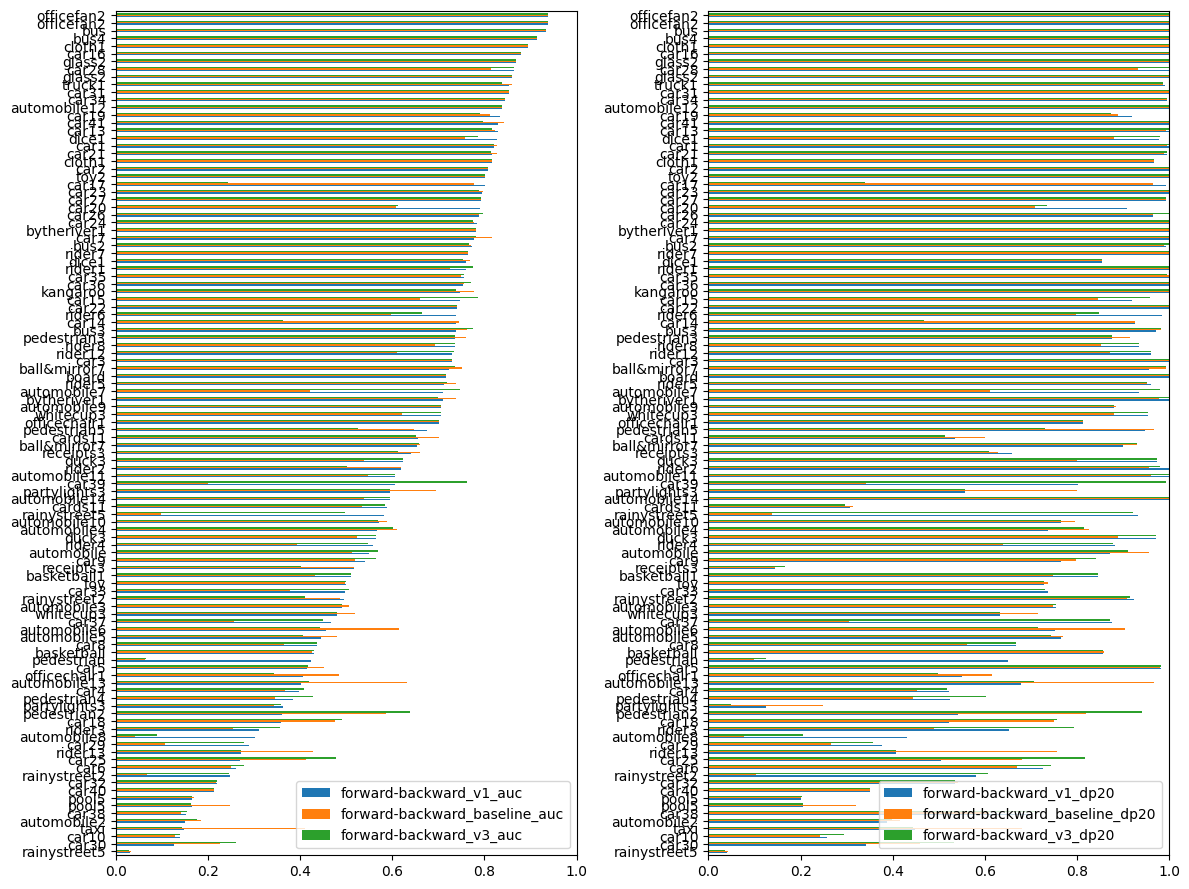

In [9]:
_, summary = eval_results_v2(
    dataset,
    ["forward-backward_v1", "forward-backward_baseline", "forward-backward_v3"],
    plot=True)
summary

In [10]:
version = "v3"

for scene in tqdm(val_scenes):
    print("scene id", scene)
    scene = val_dataset[scene]
    print("scene name", scene.name)
    
    output_dir = f"../outputs/model_predictions/forward-backward_{version}/{val_dataset.dataset_type}/{scene.camera_type}"
    pred_path = f"{output_dir}/{scene.name}.txt"
    
    if os.path.exists(pred_path):
        print("skipping - already exists")
        continue
    
    frames = scene.falsecolor
    bbox_init = scene.y_true[0]
    forward, backward = backward_forward(ostrack, frames, bbox_init, scene, debug=False, iou_thrsh=0.2)
#     iou = overlap_ratio(forward, backward)
#     forward_int = interpolate_occluded(forward, iou < 0.2)
#     save_rects
    
    output_dir = f"../outputs/model_predictions/forward-backward_{version}/{val_dataset.dataset_type}/{scene.camera_type}"
    pred_path = f"{output_dir}/{scene.name}.txt"
    os.makedirs(output_dir, exist_ok=True)
    save_rects(pred_path, forward)

  0%|                                                                                           | 0/87 [00:00<?, ?it/s]

scene id 0
scene name car3


forward:   0%|          | 0/330 [00:00<?, ?it/s]

backward:   0%|          | 0/330 [00:00<?, ?it/s]

backward:   0%|          | 0/137 [00:00<?, ?it/s]

forward:   0%|          | 0/193 [00:00<?, ?it/s]

backward:   0%|          | 0/193 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

forward:   0%|          | 0/190 [00:00<?, ?it/s]

backward:   0%|          | 0/190 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

  1%|▉                                                                                  | 1/87 [00:21<31:30, 21.99s/it]

scene id 1
scene name coin


forward:   0%|          | 0/148 [00:00<?, ?it/s]

backward:   0%|          | 0/148 [00:00<?, ?it/s]

backward:   0%|          | 0/72 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

forward:   0%|          | 0/120 [00:00<?, ?it/s]

backward:   0%|          | 0/120 [00:00<?, ?it/s]

backward:   0%|          | 0/56 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/119 [00:00<?, ?it/s]

backward:   0%|          | 0/119 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|█▉                                                                                 | 2/87 [00:34<23:03, 16.27s/it]

scene id 2
scene name cards19


forward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/117 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

forward:   0%|          | 0/231 [00:00<?, ?it/s]

backward:   0%|          | 0/231 [00:00<?, ?it/s]

  3%|██▊                                                                                | 3/87 [00:49<21:58, 15.70s/it]

scene id 3
scene name coke


forward:   0%|          | 0/730 [00:00<?, ?it/s]

backward:   0%|          | 0/730 [00:00<?, ?it/s]

backward:   0%|          | 0/357 [00:00<?, ?it/s]

forward:   0%|          | 0/373 [00:00<?, ?it/s]

backward:   0%|          | 0/373 [00:00<?, ?it/s]

backward:   0%|          | 0/182 [00:00<?, ?it/s]

backward:   0%|          | 0/78 [00:00<?, ?it/s]

forward:   0%|          | 0/295 [00:00<?, ?it/s]

backward:   0%|          | 0/295 [00:00<?, ?it/s]

backward:   0%|          | 0/139 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

  5%|███▊                                                                               | 4/87 [01:31<36:23, 26.30s/it]

scene id 4
scene name hand


forward:   0%|          | 0/183 [00:00<?, ?it/s]

backward:   0%|          | 0/183 [00:00<?, ?it/s]

  6%|████▊                                                                              | 5/87 [01:36<25:07, 18.39s/it]

scene id 5
scene name duck5


forward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/149 [00:00<?, ?it/s]

forward:   0%|          | 0/175 [00:00<?, ?it/s]

backward:   0%|          | 0/175 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/41 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|█████▋                                                                             | 6/87 [01:51<23:35, 17.48s/it]

scene id 6
scene name rubik


forward:   0%|          | 0/525 [00:00<?, ?it/s]

backward:   0%|          | 0/525 [00:00<?, ?it/s]

  8%|██████▋                                                                            | 7/87 [02:04<21:03, 15.80s/it]

scene id 7
scene name pedestrain


forward:   0%|          | 0/305 [00:00<?, ?it/s]

backward:   0%|          | 0/305 [00:00<?, ?it/s]

backward:   0%|          | 0/83 [00:00<?, ?it/s]

backward:   0%|          | 0/29 [00:00<?, ?it/s]

forward:   0%|          | 0/276 [00:00<?, ?it/s]

backward:   0%|          | 0/276 [00:00<?, ?it/s]

backward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

forward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/258 [00:00<?, ?it/s]

backward:   0%|          | 0/127 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

  9%|███████▋                                                                           | 8/87 [02:29<24:48, 18.84s/it]

scene id 8
scene name card


forward:   0%|          | 0/929 [00:00<?, ?it/s]

backward:   0%|          | 0/929 [00:00<?, ?it/s]

backward:   0%|          | 0/456 [00:00<?, ?it/s]

backward:   0%|          | 0/224 [00:00<?, ?it/s]

forward:   0%|          | 0/705 [00:00<?, ?it/s]

backward:   0%|          | 0/705 [00:00<?, ?it/s]

backward:   0%|          | 0/350 [00:00<?, ?it/s]

backward:   0%|          | 0/168 [00:00<?, ?it/s]

backward:   0%|          | 0/80 [00:00<?, ?it/s]

backward:   0%|          | 0/34 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

forward:   0%|          | 0/702 [00:00<?, ?it/s]

backward:   0%|          | 0/702 [00:00<?, ?it/s]

backward:   0%|          | 0/349 [00:00<?, ?it/s]

backward:   0%|          | 0/170 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

backward:   0%|          | 0/34 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

 10%|████████▌                                                                          | 9/87 [03:47<48:32, 37.34s/it]

scene id 9
scene name pedestrian2


forward:   0%|          | 0/362 [00:00<?, ?it/s]

backward:   0%|          | 0/362 [00:00<?, ?it/s]

backward:   0%|          | 0/131 [00:00<?, ?it/s]

forward:   0%|          | 0/231 [00:00<?, ?it/s]

backward:   0%|          | 0/231 [00:00<?, ?it/s]

backward:   0%|          | 0/36 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/219 [00:00<?, ?it/s]

backward:   0%|          | 0/219 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 11%|█████████▍                                                                        | 10/87 [04:09<41:59, 32.72s/it]

scene id 10
scene name basketball


forward:   0%|          | 0/185 [00:00<?, ?it/s]

backward:   0%|          | 0/185 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

forward:   0%|          | 0/145 [00:00<?, ?it/s]

backward:   0%|          | 0/145 [00:00<?, ?it/s]

backward:   0%|          | 0/70 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 13%|██████████▎                                                                       | 11/87 [04:25<34:47, 27.46s/it]

scene id 11
scene name student


forward:   0%|          | 0/395 [00:00<?, ?it/s]

backward:   0%|          | 0/395 [00:00<?, ?it/s]

 14%|███████████▎                                                                      | 12/87 [04:34<27:28, 21.97s/it]

scene id 12
scene name rainystreet16


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/190 [00:00<?, ?it/s]

backward:   0%|          | 0/88 [00:00<?, ?it/s]

forward:   0%|          | 0/311 [00:00<?, ?it/s]

backward:   0%|          | 0/311 [00:00<?, ?it/s]

backward:   0%|          | 0/153 [00:00<?, ?it/s]

backward:   0%|          | 0/67 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

 15%|████████████▎                                                                     | 13/87 [04:58<27:42, 22.46s/it]

scene id 13
scene name board


forward:   0%|          | 0/470 [00:00<?, ?it/s]

backward:   0%|          | 0/470 [00:00<?, ?it/s]

 16%|█████████████▏                                                                    | 14/87 [05:09<23:06, 18.99s/it]

scene id 14
scene name ball&mirror9


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

forward:   0%|          | 0/202 [00:00<?, ?it/s]

backward:   0%|          | 0/202 [00:00<?, ?it/s]

backward:   0%|          | 0/98 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

forward:   0%|          | 0/188 [00:00<?, ?it/s]

backward:   0%|          | 0/188 [00:00<?, ?it/s]

backward:   0%|          | 0/91 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 17%|██████████████▏                                                                   | 15/87 [05:28<22:54, 19.09s/it]

scene id 15
scene name pool10


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

forward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/46 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/203 [00:00<?, ?it/s]

backward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 18%|███████████████                                                                   | 16/87 [05:51<23:51, 20.16s/it]

scene id 16
scene name worker


forward:   0%|          | 0/1208 [00:00<?, ?it/s]

backward:   0%|          | 0/1208 [00:00<?, ?it/s]

backward:   0%|          | 0/588 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/29 [00:00<?, ?it/s]

forward:   0%|          | 0/1179 [00:00<?, ?it/s]

backward:   0%|          | 0/1179 [00:00<?, ?it/s]

backward:   0%|          | 0/585 [00:00<?, ?it/s]

backward:   0%|          | 0/289 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

 20%|████████████████                                                                  | 17/87 [07:06<42:55, 36.79s/it]

scene id 17
scene name forest


forward:   0%|          | 0/529 [00:00<?, ?it/s]

backward:   0%|          | 0/529 [00:00<?, ?it/s]

backward:   0%|          | 0/159 [00:00<?, ?it/s]

forward:   0%|          | 0/370 [00:00<?, ?it/s]

backward:   0%|          | 0/370 [00:00<?, ?it/s]

backward:   0%|          | 0/167 [00:00<?, ?it/s]

backward:   0%|          | 0/73 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

 21%|████████████████▉                                                                 | 18/87 [07:33<38:42, 33.65s/it]

scene id 18
scene name kangaroo


forward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/116 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|█████████████████▉                                                                | 19/87 [07:43<30:07, 26.58s/it]

scene id 19
scene name excavator


forward:   0%|          | 0/500 [00:00<?, ?it/s]

backward:   0%|          | 0/500 [00:00<?, ?it/s]

 23%|██████████████████▊                                                               | 20/87 [07:55<24:48, 22.21s/it]

scene id 20
scene name playground


forward:   0%|          | 0/799 [00:00<?, ?it/s]

backward:   0%|          | 0/799 [00:00<?, ?it/s]

backward:   0%|          | 0/382 [00:00<?, ?it/s]

backward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/88 [00:00<?, ?it/s]

forward:   0%|          | 0/711 [00:00<?, ?it/s]

backward:   0%|          | 0/711 [00:00<?, ?it/s]

backward:   0%|          | 0/343 [00:00<?, ?it/s]

backward:   0%|          | 0/155 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/699 [00:00<?, ?it/s]

backward:   0%|          | 0/699 [00:00<?, ?it/s]

backward:   0%|          | 0/337 [00:00<?, ?it/s]

backward:   0%|          | 0/158 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 24%|███████████████████▊                                                              | 21/87 [09:10<41:49, 38.02s/it]

scene id 21
scene name car


forward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/100 [00:00<?, ?it/s]

 25%|████████████████████▋                                                             | 22/87 [09:12<29:35, 27.31s/it]

scene id 22
scene name face


forward:   0%|          | 0/278 [00:00<?, ?it/s]

backward:   0%|          | 0/278 [00:00<?, ?it/s]

 26%|█████████████████████▋                                                            | 23/87 [09:19<22:28, 21.07s/it]

scene id 23
scene name whitecup1


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

 28%|██████████████████████▌                                                           | 24/87 [09:28<18:28, 17.60s/it]

scene id 24
scene name ball


forward:   0%|          | 0/624 [00:00<?, ?it/s]

backward:   0%|          | 0/624 [00:00<?, ?it/s]

backward:   0%|          | 0/293 [00:00<?, ?it/s]

backward:   0%|          | 0/138 [00:00<?, ?it/s]

backward:   0%|          | 0/67 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

forward:   0%|          | 0/602 [00:00<?, ?it/s]

backward:   0%|          | 0/602 [00:00<?, ?it/s]

backward:   0%|          | 0/297 [00:00<?, ?it/s]

backward:   0%|          | 0/146 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

backward:   0%|          | 0/29 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

 29%|███████████████████████▌                                                          | 25/87 [10:10<25:36, 24.78s/it]

scene id 25
scene name rider1


forward:   0%|          | 0/335 [00:00<?, ?it/s]

backward:   0%|          | 0/335 [00:00<?, ?it/s]

backward:   0%|          | 0/154 [00:00<?, ?it/s]

forward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/83 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/176 [00:00<?, ?it/s]

backward:   0%|          | 0/176 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

 30%|████████████████████████▌                                                         | 26/87 [10:31<24:01, 23.62s/it]

scene id 26
scene name toy2


forward:   0%|          | 0/600 [00:00<?, ?it/s]

backward:   0%|          | 0/600 [00:00<?, ?it/s]

backward:   0%|          | 0/226 [00:00<?, ?it/s]

backward:   0%|          | 0/101 [00:00<?, ?it/s]

forward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/499 [00:00<?, ?it/s]

backward:   0%|          | 0/239 [00:00<?, ?it/s]

backward:   0%|          | 0/110 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

 31%|█████████████████████████▍                                                        | 27/87 [11:06<27:03, 27.05s/it]

scene id 27
scene name car2


forward:   0%|          | 0/130 [00:00<?, ?it/s]

backward:   0%|          | 0/130 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

forward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/36 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/77 [00:00<?, ?it/s]

backward:   0%|          | 0/77 [00:00<?, ?it/s]

backward:   0%|          | 0/30 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

 32%|██████████████████████████▍                                                       | 28/87 [11:14<21:04, 21.43s/it]

scene id 28
scene name dice2


forward:   0%|          | 0/449 [00:00<?, ?it/s]

backward:   0%|          | 0/449 [00:00<?, ?it/s]

backward:   0%|          | 0/145 [00:00<?, ?it/s]

forward:   0%|          | 0/304 [00:00<?, ?it/s]

backward:   0%|          | 0/304 [00:00<?, ?it/s]

backward:   0%|          | 0/142 [00:00<?, ?it/s]

backward:   0%|          | 0/66 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

forward:   0%|          | 0/285 [00:00<?, ?it/s]

backward:   0%|          | 0/285 [00:00<?, ?it/s]

backward:   0%|          | 0/139 [00:00<?, ?it/s]

backward:   0%|          | 0/63 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

 33%|███████████████████████████▎                                                      | 29/87 [11:46<23:52, 24.71s/it]

scene id 29
scene name partylights6


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/118 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/244 [00:00<?, ?it/s]

backward:   0%|          | 0/244 [00:00<?, ?it/s]

backward:   0%|          | 0/120 [00:00<?, ?it/s]

backward:   0%|          | 0/58 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

forward:   0%|          | 0/240 [00:00<?, ?it/s]

backward:   0%|          | 0/240 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

 34%|████████████████████████████▎                                                     | 30/87 [12:12<23:42, 24.95s/it]

scene id 30
scene name campus


forward:   0%|          | 0/975 [00:00<?, ?it/s]

backward:   0%|          | 0/975 [00:00<?, ?it/s]

backward:   0%|          | 0/484 [00:00<?, ?it/s]

backward:   0%|          | 0/228 [00:00<?, ?it/s]

backward:   0%|          | 0/112 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

forward:   0%|          | 0/954 [00:00<?, ?it/s]

backward:   0%|          | 0/954 [00:00<?, ?it/s]

backward:   0%|          | 0/460 [00:00<?, ?it/s]

backward:   0%|          | 0/192 [00:00<?, ?it/s]

backward:   0%|          | 0/94 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

forward:   0%|          | 0/944 [00:00<?, ?it/s]

backward:   0%|          | 0/944 [00:00<?, ?it/s]

backward:   0%|          | 0/466 [00:00<?, ?it/s]

backward:   0%|          | 0/230 [00:00<?, ?it/s]

backward:   0%|          | 0/108 [00:00<?, ?it/s]

backward:   0%|          | 0/46 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

 36%|█████████████████████████████▏                                                    | 31/87 [13:48<43:09, 46.23s/it]

scene id 31
scene name book


forward:   0%|          | 0/600 [00:00<?, ?it/s]

backward:   0%|          | 0/600 [00:00<?, ?it/s]

 37%|██████████████████████████████▏                                                   | 32/87 [14:02<33:29, 36.55s/it]

scene id 32
scene name rainystreet10


forward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/90 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

forward:   0%|          | 0/243 [00:00<?, ?it/s]

backward:   0%|          | 0/243 [00:00<?, ?it/s]

backward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/55 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/236 [00:00<?, ?it/s]

backward:   0%|          | 0/236 [00:00<?, ?it/s]

backward:   0%|          | 0/107 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

 38%|███████████████████████████████                                                   | 33/87 [14:25<29:27, 32.72s/it]

scene id 33
scene name cards16


forward:   0%|          | 0/374 [00:00<?, ?it/s]

backward:   0%|          | 0/374 [00:00<?, ?it/s]

backward:   0%|          | 0/182 [00:00<?, ?it/s]

backward:   0%|          | 0/88 [00:00<?, ?it/s]

 39%|████████████████████████████████                                                  | 34/87 [14:38<23:37, 26.75s/it]

scene id 34
scene name rider2


forward:   0%|          | 0/209 [00:00<?, ?it/s]

backward:   0%|          | 0/209 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

forward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/70 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

forward:   0%|          | 0/134 [00:00<?, ?it/s]

backward:   0%|          | 0/134 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 40%|████████████████████████████████▉                                                 | 35/87 [14:53<20:05, 23.18s/it]

scene id 35
scene name bus2


forward:   0%|          | 0/325 [00:00<?, ?it/s]

backward:   0%|          | 0/325 [00:00<?, ?it/s]

 41%|█████████████████████████████████▉                                                | 36/87 [15:01<15:44, 18.52s/it]

scene id 36
scene name trucker


forward:   0%|          | 0/220 [00:00<?, ?it/s]

backward:   0%|          | 0/220 [00:00<?, ?it/s]

 43%|██████████████████████████████████▊                                               | 37/87 [15:06<12:06, 14.53s/it]

scene id 37
scene name drive


forward:   0%|          | 0/724 [00:00<?, ?it/s]

backward:   0%|          | 0/724 [00:00<?, ?it/s]

backward:   0%|          | 0/330 [00:00<?, ?it/s]

backward:   0%|          | 0/163 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

forward:   0%|          | 0/710 [00:00<?, ?it/s]

backward:   0%|          | 0/710 [00:00<?, ?it/s]

backward:   0%|          | 0/328 [00:00<?, ?it/s]

backward:   0%|          | 0/162 [00:00<?, ?it/s]

backward:   0%|          | 0/60 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

forward:   0%|          | 0/706 [00:00<?, ?it/s]

backward:   0%|          | 0/706 [00:00<?, ?it/s]

backward:   0%|          | 0/328 [00:00<?, ?it/s]

backward:   0%|          | 0/142 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

 44%|███████████████████████████████████▊                                              | 38/87 [16:14<25:01, 30.64s/it]

scene id 38
scene name fruit


forward:   0%|          | 0/551 [00:00<?, ?it/s]

backward:   0%|          | 0/551 [00:00<?, ?it/s]

backward:   0%|          | 0/253 [00:00<?, ?it/s]

backward:   0%|          | 0/120 [00:00<?, ?it/s]

forward:   0%|          | 0/431 [00:00<?, ?it/s]

backward:   0%|          | 0/431 [00:00<?, ?it/s]

backward:   0%|          | 0/211 [00:00<?, ?it/s]

backward:   0%|          | 0/101 [00:00<?, ?it/s]

backward:   0%|          | 0/46 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/425 [00:00<?, ?it/s]

backward:   0%|          | 0/425 [00:00<?, ?it/s]

backward:   0%|          | 0/208 [00:00<?, ?it/s]

backward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 45%|████████████████████████████████████▊                                             | 39/87 [17:02<28:30, 35.64s/it]

scene id 39
scene name paper


forward:   0%|          | 0/277 [00:00<?, ?it/s]

backward:   0%|          | 0/277 [00:00<?, ?it/s]

backward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

forward:   0%|          | 0/252 [00:00<?, ?it/s]

backward:   0%|          | 0/252 [00:00<?, ?it/s]

backward:   0%|          | 0/95 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

forward:   0%|          | 0/235 [00:00<?, ?it/s]

backward:   0%|          | 0/235 [00:00<?, ?it/s]

backward:   0%|          | 0/93 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|█████████████████████████████████████▋                                            | 40/87 [17:24<24:44, 31.58s/it]

scene id 40
scene name forest2


forward:   0%|          | 0/362 [00:00<?, ?it/s]

backward:   0%|          | 0/362 [00:00<?, ?it/s]

 47%|██████████████████████████████████████▋                                           | 41/87 [17:32<18:55, 24.69s/it]

scene id 41
scene name face2


forward:   0%|          | 0/1110 [00:00<?, ?it/s]

backward:   0%|          | 0/1110 [00:00<?, ?it/s]

backward:   0%|          | 0/494 [00:00<?, ?it/s]

forward:   0%|          | 0/616 [00:00<?, ?it/s]

backward:   0%|          | 0/616 [00:00<?, ?it/s]

backward:   0%|          | 0/285 [00:00<?, ?it/s]

backward:   0%|          | 0/122 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

 48%|███████████████████████████████████████▌                                          | 42/87 [18:24<24:36, 32.80s/it]

scene id 42
scene name toy1


forward:   0%|          | 0/375 [00:00<?, ?it/s]

backward:   0%|          | 0/375 [00:00<?, ?it/s]

backward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

forward:   0%|          | 0/294 [00:00<?, ?it/s]

backward:   0%|          | 0/294 [00:00<?, ?it/s]

backward:   0%|          | 0/136 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

forward:   0%|          | 0/279 [00:00<?, ?it/s]

backward:   0%|          | 0/279 [00:00<?, ?it/s]

backward:   0%|          | 0/137 [00:00<?, ?it/s]

backward:   0%|          | 0/54 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

 49%|████████████████████████████████████████▌                                         | 43/87 [18:53<23:16, 31.74s/it]

scene id 43
scene name bus


forward:   0%|          | 0/130 [00:00<?, ?it/s]

backward:   0%|          | 0/130 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

forward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/85 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/84 [00:00<?, ?it/s]

backward:   0%|          | 0/84 [00:00<?, ?it/s]

backward:   0%|          | 0/38 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████████████████████████████████████████▍                                        | 44/87 [19:02<17:48, 24.84s/it]

scene id 44
scene name pool11


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/120 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

forward:   0%|          | 0/200 [00:00<?, ?it/s]

backward:   0%|          | 0/200 [00:00<?, ?it/s]

backward:   0%|          | 0/61 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/198 [00:00<?, ?it/s]

backward:   0%|          | 0/198 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/41 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████▍                                       | 45/87 [19:24<16:44, 23.92s/it]

scene id 45
scene name player


forward:   0%|          | 0/900 [00:00<?, ?it/s]

backward:   0%|          | 0/900 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████▎                                      | 46/87 [19:45<15:49, 23.16s/it]

scene id 46
scene name car52


forward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

forward:   0%|          | 0/79 [00:00<?, ?it/s]

backward:   0%|          | 0/79 [00:00<?, ?it/s]

backward:   0%|          | 0/34 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

forward:   0%|          | 0/75 [00:00<?, ?it/s]

backward:   0%|          | 0/75 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|████████████████████████████████████████████▎                                     | 47/87 [19:52<12:14, 18.35s/it]

scene id 47
scene name car84


forward:   0%|          | 0/177 [00:00<?, ?it/s]

backward:   0%|          | 0/177 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████▏                                    | 48/87 [19:57<09:10, 14.12s/it]

scene id 48
scene name car60


forward:   0%|          | 0/81 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

forward:   0%|          | 0/59 [00:00<?, ?it/s]

backward:   0%|          | 0/59 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

forward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/13 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████▏                                   | 49/87 [20:02<07:12, 11.39s/it]

scene id 49
scene name car79


forward:   0%|          | 0/131 [00:00<?, ?it/s]

backward:   0%|          | 0/131 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

forward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/32 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

forward:   0%|          | 0/78 [00:00<?, ?it/s]

backward:   0%|          | 0/78 [00:00<?, ?it/s]

backward:   0%|          | 0/34 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

 57%|███████████████████████████████████████████████▏                                  | 50/87 [20:10<06:31, 10.59s/it]

scene id 50
scene name basketball3


forward:   0%|          | 0/777 [00:00<?, ?it/s]

backward:   0%|          | 0/777 [00:00<?, ?it/s]

backward:   0%|          | 0/383 [00:00<?, ?it/s]

backward:   0%|          | 0/190 [00:00<?, ?it/s]

backward:   0%|          | 0/91 [00:00<?, ?it/s]

backward:   0%|          | 0/44 [00:00<?, ?it/s]

forward:   0%|          | 0/733 [00:00<?, ?it/s]

backward:   0%|          | 0/733 [00:00<?, ?it/s]

backward:   0%|          | 0/359 [00:00<?, ?it/s]

backward:   0%|          | 0/177 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/731 [00:00<?, ?it/s]

backward:   0%|          | 0/731 [00:00<?, ?it/s]

backward:   0%|          | 0/364 [00:00<?, ?it/s]

backward:   0%|          | 0/180 [00:00<?, ?it/s]

backward:   0%|          | 0/88 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████                                  | 51/87 [21:29<18:35, 30.98s/it]

scene id 51
scene name car83


forward:   0%|          | 0/121 [00:00<?, ?it/s]

backward:   0%|          | 0/121 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████                                 | 52/87 [21:32<13:09, 22.56s/it]

scene id 52
scene name rider17


forward:   0%|          | 0/164 [00:00<?, ?it/s]

backward:   0%|          | 0/164 [00:00<?, ?it/s]

backward:   0%|          | 0/74 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

forward:   0%|          | 0/155 [00:00<?, ?it/s]

backward:   0%|          | 0/155 [00:00<?, ?it/s]

backward:   0%|          | 0/74 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

forward:   0%|          | 0/136 [00:00<?, ?it/s]

backward:   0%|          | 0/136 [00:00<?, ?it/s]

backward:   0%|          | 0/65 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

 61%|█████████████████████████████████████████████████▉                                | 53/87 [21:46<11:20, 20.03s/it]

scene id 53
scene name pedestrian7


forward:   0%|          | 0/270 [00:00<?, ?it/s]

backward:   0%|          | 0/270 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/262 [00:00<?, ?it/s]

backward:   0%|          | 0/262 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/255 [00:00<?, ?it/s]

backward:   0%|          | 0/255 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████▉                               | 54/87 [22:05<10:49, 19.70s/it]

scene id 54
scene name car51


forward:   0%|          | 0/101 [00:00<?, ?it/s]

backward:   0%|          | 0/101 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/94 [00:00<?, ?it/s]

backward:   0%|          | 0/94 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/86 [00:00<?, ?it/s]

backward:   0%|          | 0/36 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████▊                              | 55/87 [22:13<08:38, 16.21s/it]

scene id 55
scene name rider19


forward:   0%|          | 0/159 [00:00<?, ?it/s]

backward:   0%|          | 0/159 [00:00<?, ?it/s]

 64%|████████████████████████████████████████████████████▊                             | 56/87 [22:17<06:27, 12.49s/it]

scene id 56
scene name car63


forward:   0%|          | 0/150 [00:00<?, ?it/s]

backward:   0%|          | 0/150 [00:00<?, ?it/s]

 66%|█████████████████████████████████████████████████████▋                            | 57/87 [22:20<04:54,  9.82s/it]

scene id 57
scene name car77


forward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████▋                           | 58/87 [22:22<03:38,  7.53s/it]

scene id 58
scene name car64


forward:   0%|          | 0/67 [00:00<?, ?it/s]

backward:   0%|          | 0/67 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████▌                          | 59/87 [22:24<02:41,  5.76s/it]

scene id 59
scene name car80


forward:   0%|          | 0/163 [00:00<?, ?it/s]

backward:   0%|          | 0/163 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

forward:   0%|          | 0/110 [00:00<?, ?it/s]

backward:   0%|          | 0/110 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/102 [00:00<?, ?it/s]

backward:   0%|          | 0/102 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████▌                         | 60/87 [22:35<03:17,  7.31s/it]

scene id 60
scene name car11


forward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/100 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

forward:   0%|          | 0/75 [00:00<?, ?it/s]

backward:   0%|          | 0/75 [00:00<?, ?it/s]

backward:   0%|          | 0/33 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

forward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/27 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 61/87 [22:42<03:07,  7.22s/it]

scene id 61
scene name car82


forward:   0%|          | 0/104 [00:00<?, ?it/s]

backward:   0%|          | 0/104 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████▍                       | 62/87 [22:45<02:24,  5.80s/it]

scene id 62
scene name rider16


forward:   0%|          | 0/183 [00:00<?, ?it/s]

backward:   0%|          | 0/183 [00:00<?, ?it/s]

backward:   0%|          | 0/75 [00:00<?, ?it/s]

forward:   0%|          | 0/108 [00:00<?, ?it/s]

backward:   0%|          | 0/108 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

forward:   0%|          | 0/101 [00:00<?, ?it/s]

backward:   0%|          | 0/101 [00:00<?, ?it/s]

backward:   0%|          | 0/22 [00:00<?, ?it/s]

 72%|███████████████████████████████████████████████████████████▍                      | 63/87 [22:55<02:56,  7.35s/it]

scene id 63
scene name car78


forward:   0%|          | 0/118 [00:00<?, ?it/s]

backward:   0%|          | 0/118 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

forward:   0%|          | 0/106 [00:00<?, ?it/s]

backward:   0%|          | 0/106 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

forward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

 74%|████████████████████████████████████████████████████████████▎                     | 64/87 [23:04<02:56,  7.66s/it]

scene id 64
scene name rider11


forward:   0%|          | 0/141 [00:00<?, ?it/s]

backward:   0%|          | 0/141 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████▎                    | 65/87 [23:07<02:20,  6.38s/it]

scene id 65
scene name car53


forward:   0%|          | 0/159 [00:00<?, ?it/s]

backward:   0%|          | 0/159 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

forward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/144 [00:00<?, ?it/s]

backward:   0%|          | 0/66 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/139 [00:00<?, ?it/s]

backward:   0%|          | 0/139 [00:00<?, ?it/s]

backward:   0%|          | 0/63 [00:00<?, ?it/s]

backward:   0%|          | 0/12 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████▏                   | 66/87 [23:20<02:52,  8.22s/it]

scene id 66
scene name car59


forward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/184 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

forward:   0%|          | 0/164 [00:00<?, ?it/s]

backward:   0%|          | 0/164 [00:00<?, ?it/s]

backward:   0%|          | 0/73 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

forward:   0%|          | 0/133 [00:00<?, ?it/s]

backward:   0%|          | 0/133 [00:00<?, ?it/s]

backward:   0%|          | 0/60 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████████████████████████▏                  | 67/87 [23:34<03:22, 10.14s/it]

scene id 67
scene name car61


forward:   0%|          | 0/126 [00:00<?, ?it/s]

backward:   0%|          | 0/126 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

forward:   0%|          | 0/69 [00:00<?, ?it/s]

backward:   0%|          | 0/69 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/64 [00:00<?, ?it/s]

backward:   0%|          | 0/28 [00:00<?, ?it/s]

backward:   0%|          | 0/7 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████                  | 68/87 [23:42<02:59,  9.44s/it]

scene id 68
scene name car85


forward:   0%|          | 0/154 [00:00<?, ?it/s]

backward:   0%|          | 0/154 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████                 | 69/87 [23:46<02:18,  7.72s/it]

scene id 69
scene name car81


forward:   0%|          | 0/110 [00:00<?, ?it/s]

backward:   0%|          | 0/110 [00:00<?, ?it/s]

backward:   0%|          | 0/48 [00:00<?, ?it/s]

forward:   0%|          | 0/62 [00:00<?, ?it/s]

backward:   0%|          | 0/62 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/56 [00:00<?, ?it/s]

backward:   0%|          | 0/56 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████▉                | 70/87 [23:53<02:06,  7.44s/it]

scene id 70
scene name car12


forward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/181 [00:00<?, ?it/s]

backward:   0%|          | 0/83 [00:00<?, ?it/s]

forward:   0%|          | 0/98 [00:00<?, ?it/s]

backward:   0%|          | 0/98 [00:00<?, ?it/s]

backward:   0%|          | 0/47 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

 82%|██████████████████████████████████████████████████████████████████▉               | 71/87 [24:04<02:16,  8.53s/it]

scene id 71
scene name car76


forward:   0%|          | 0/137 [00:00<?, ?it/s]

backward:   0%|          | 0/137 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████▊              | 72/87 [24:07<01:44,  6.96s/it]

scene id 72
scene name car49


forward:   0%|          | 0/149 [00:00<?, ?it/s]

backward:   0%|          | 0/149 [00:00<?, ?it/s]

backward:   0%|          | 0/14 [00:00<?, ?it/s]

forward:   0%|          | 0/135 [00:00<?, ?it/s]

backward:   0%|          | 0/135 [00:00<?, ?it/s]

backward:   0%|          | 0/63 [00:00<?, ?it/s]

forward:   0%|          | 0/72 [00:00<?, ?it/s]

backward:   0%|          | 0/72 [00:00<?, ?it/s]

backward:   0%|          | 0/31 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████▊             | 73/87 [24:17<01:50,  7.88s/it]

scene id 73
scene name car50


forward:   0%|          | 0/154 [00:00<?, ?it/s]

backward:   0%|          | 0/154 [00:00<?, ?it/s]

backward:   0%|          | 0/74 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

forward:   0%|          | 0/135 [00:00<?, ?it/s]

backward:   0%|          | 0/135 [00:00<?, ?it/s]

backward:   0%|          | 0/54 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

forward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████▋            | 74/87 [24:29<01:59,  9.22s/it]

scene id 74
scene name rider18


forward:   0%|          | 0/123 [00:00<?, ?it/s]

backward:   0%|          | 0/123 [00:00<?, ?it/s]

backward:   0%|          | 0/58 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

forward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/114 [00:00<?, ?it/s]

backward:   0%|          | 0/51 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

forward:   0%|          | 0/111 [00:00<?, ?it/s]

backward:   0%|          | 0/111 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/19 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████▋           | 75/87 [24:40<01:56,  9.72s/it]

scene id 75
scene name car62


forward:   0%|          | 0/158 [00:00<?, ?it/s]

backward:   0%|          | 0/158 [00:00<?, ?it/s]

backward:   0%|          | 0/40 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/157 [00:00<?, ?it/s]

backward:   0%|          | 0/157 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

backward:   0%|          | 0/3 [00:00<?, ?it/s]

forward:   0%|          | 0/154 [00:00<?, ?it/s]

backward:   0%|          | 0/154 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████▋          | 76/87 [24:53<01:56, 10.57s/it]

scene id 76
scene name pool11


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/81 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

forward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/210 [00:00<?, ?it/s]

backward:   0%|          | 0/103 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

backward:   0%|          | 0/10 [00:00<?, ?it/s]

forward:   0%|          | 0/200 [00:00<?, ?it/s]

backward:   0%|          | 0/200 [00:00<?, ?it/s]

backward:   0%|          | 0/77 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████▌         | 77/87 [25:15<02:19, 13.94s/it]

scene id 77
scene name ball&mirror9


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/45 [00:00<?, ?it/s]

forward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/204 [00:00<?, ?it/s]

backward:   0%|          | 0/99 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

forward:   0%|          | 0/189 [00:00<?, ?it/s]

backward:   0%|          | 0/189 [00:00<?, ?it/s]

backward:   0%|          | 0/92 [00:00<?, ?it/s]

backward:   0%|          | 0/43 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████▌        | 78/87 [25:34<02:21, 15.69s/it]

scene id 78
scene name cards19


forward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/108 [00:00<?, ?it/s]

backward:   0%|          | 0/49 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/269 [00:00<?, ?it/s]

backward:   0%|          | 0/269 [00:00<?, ?it/s]

backward:   0%|          | 0/89 [00:00<?, ?it/s]

backward:   0%|          | 0/39 [00:00<?, ?it/s]

forward:   0%|          | 0/230 [00:00<?, ?it/s]

backward:   0%|          | 0/230 [00:00<?, ?it/s]

backward:   0%|          | 0/113 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

 91%|██████████████████████████████████████████████████████████████████████████▍       | 79/87 [26:00<02:28, 18.54s/it]

scene id 79
scene name whitecup1


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 80/87 [26:09<01:50, 15.84s/it]

scene id 80
scene name dice2


forward:   0%|          | 0/449 [00:00<?, ?it/s]

backward:   0%|          | 0/449 [00:00<?, ?it/s]

backward:   0%|          | 0/189 [00:00<?, ?it/s]

backward:   0%|          | 0/42 [00:00<?, ?it/s]

forward:   0%|          | 0/407 [00:00<?, ?it/s]

backward:   0%|          | 0/407 [00:00<?, ?it/s]

backward:   0%|          | 0/152 [00:00<?, ?it/s]

backward:   0%|          | 0/21 [00:00<?, ?it/s]

forward:   0%|          | 0/386 [00:00<?, ?it/s]

backward:   0%|          | 0/386 [00:00<?, ?it/s]

backward:   0%|          | 0/140 [00:00<?, ?it/s]

backward:   0%|          | 0/59 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████▎     | 81/87 [26:47<02:13, 22.29s/it]

scene id 81
scene name rainystreet16


forward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/399 [00:00<?, ?it/s]

backward:   0%|          | 0/194 [00:00<?, ?it/s]

backward:   0%|          | 0/87 [00:00<?, ?it/s]

forward:   0%|          | 0/312 [00:00<?, ?it/s]

backward:   0%|          | 0/312 [00:00<?, ?it/s]

backward:   0%|          | 0/153 [00:00<?, ?it/s]

backward:   0%|          | 0/74 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

forward:   0%|          | 0/311 [00:00<?, ?it/s]

backward:   0%|          | 0/311 [00:00<?, ?it/s]

backward:   0%|          | 0/153 [00:00<?, ?it/s]

backward:   0%|          | 0/74 [00:00<?, ?it/s]

backward:   0%|          | 0/35 [00:00<?, ?it/s]

backward:   0%|          | 0/15 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████▎    | 82/87 [27:21<02:10, 26.03s/it]

scene id 82
scene name pool10


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/75 [00:00<?, ?it/s]

backward:   0%|          | 0/20 [00:00<?, ?it/s]

forward:   0%|          | 0/229 [00:00<?, ?it/s]

backward:   0%|          | 0/229 [00:00<?, ?it/s]

backward:   0%|          | 0/88 [00:00<?, ?it/s]

backward:   0%|          | 0/29 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/221 [00:00<?, ?it/s]

backward:   0%|          | 0/221 [00:00<?, ?it/s]

backward:   0%|          | 0/25 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████▏   | 83/87 [27:43<01:38, 24.67s/it]

scene id 83
scene name partylights6


forward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/249 [00:00<?, ?it/s]

backward:   0%|          | 0/121 [00:00<?, ?it/s]

backward:   0%|          | 0/59 [00:00<?, ?it/s]

backward:   0%|          | 0/24 [00:00<?, ?it/s]

backward:   0%|          | 0/9 [00:00<?, ?it/s]

backward:   0%|          | 0/2 [00:00<?, ?it/s]

forward:   0%|          | 0/247 [00:00<?, ?it/s]

backward:   0%|          | 0/247 [00:00<?, ?it/s]

backward:   0%|          | 0/118 [00:00<?, ?it/s]

backward:   0%|          | 0/53 [00:00<?, ?it/s]

backward:   0%|          | 0/18 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/241 [00:00<?, ?it/s]

backward:   0%|          | 0/241 [00:00<?, ?it/s]

backward:   0%|          | 0/118 [00:00<?, ?it/s]

backward:   0%|          | 0/57 [00:00<?, ?it/s]

backward:   0%|          | 0/26 [00:00<?, ?it/s]

backward:   0%|          | 0/11 [00:00<?, ?it/s]

backward:   0%|          | 0/4 [00:00<?, ?it/s]

 97%|███████████████████████████████████████████████████████████████████████████████▏  | 84/87 [28:09<01:15, 25.20s/it]

scene id 84
scene name duck5


forward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/324 [00:00<?, ?it/s]

backward:   0%|          | 0/155 [00:00<?, ?it/s]

backward:   0%|          | 0/5 [00:00<?, ?it/s]

forward:   0%|          | 0/319 [00:00<?, ?it/s]

backward:   0%|          | 0/319 [00:00<?, ?it/s]

backward:   0%|          | 0/158 [00:00<?, ?it/s]

forward:   0%|          | 0/161 [00:00<?, ?it/s]

backward:   0%|          | 0/161 [00:00<?, ?it/s]

backward:   0%|          | 0/78 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

backward:   0%|          | 0/16 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

backward:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████  | 85/87 [28:34<00:50, 25.11s/it]

scene id 85
scene name rainystreet10


forward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/274 [00:00<?, ?it/s]

backward:   0%|          | 0/23 [00:00<?, ?it/s]

forward:   0%|          | 0/251 [00:00<?, ?it/s]

backward:   0%|          | 0/251 [00:00<?, ?it/s]

backward:   0%|          | 0/115 [00:00<?, ?it/s]

backward:   0%|          | 0/52 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

forward:   0%|          | 0/245 [00:00<?, ?it/s]

backward:   0%|          | 0/245 [00:00<?, ?it/s]

backward:   0%|          | 0/113 [00:00<?, ?it/s]

backward:   0%|          | 0/50 [00:00<?, ?it/s]

backward:   0%|          | 0/17 [00:00<?, ?it/s]

backward:   0%|          | 0/6 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████ | 86/87 [28:57<00:24, 24.55s/it]

scene id 86
scene name cards16


forward:   0%|          | 0/374 [00:00<?, ?it/s]

backward:   0%|          | 0/374 [00:00<?, ?it/s]

backward:   0%|          | 0/141 [00:00<?, ?it/s]

forward:   0%|          | 0/233 [00:00<?, ?it/s]

backward:   0%|          | 0/233 [00:00<?, ?it/s]

backward:   0%|          | 0/96 [00:00<?, ?it/s]

backward:   0%|          | 0/8 [00:00<?, ?it/s]

forward:   0%|          | 0/225 [00:00<?, ?it/s]

backward:   0%|          | 0/225 [00:00<?, ?it/s]

backward:   0%|          | 0/95 [00:00<?, ?it/s]

backward:   0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [29:23<00:00, 20.27s/it]


metric,model,mean AUC,mean DP20
1,forward-backward_v3,0.605431,0.820590
0,forward-backward_baseline,0.599976,0.805493


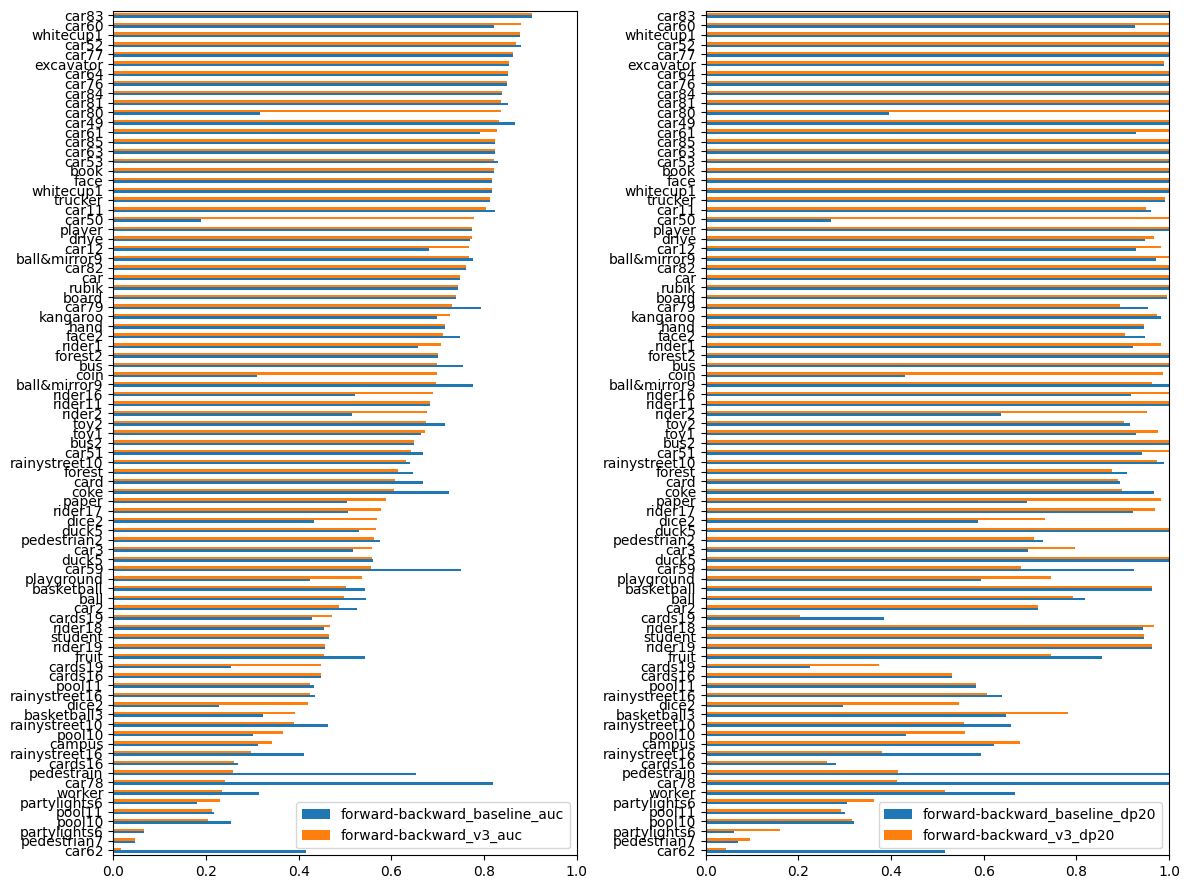

In [11]:
_, summary = eval_results_v2(
    val_dataset,
#     ["forward-backward", "forward-backward_int", "lo_baseline", "forward-backward_baseline",
#     "forward-backward_v2", "forward-backward_v2_int", "forward-backward_v3"],
    ["forward-backward_baseline", "forward-backward_v3"],
    plot=True)
summary